<a href="https://colab.research.google.com/github/UN-GCPDS/Unemployment-Rate-Prediction/blob/main/Unsupervised_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Local Biplot based on Nonlinear Dimensionality Reduction
UMAP :

https://umap-learn.readthedocs.io/en/latest/

https://arxiv.org/abs/1802.03426

# Affine Transformation

https://people.computing.clemson.edu/~dhouse/courses/401/notes/affines-matrices.pdf

We may wish to define one object
relative to another

$$\begin{bmatrix}x'\\y'\end{bmatrix}=\begin{bmatrix}a & b\\c & d\end{bmatrix}\begin{bmatrix}x\\y\end{bmatrix}$$

$$\mathbf{x}' = \mathbf{M}\mathbf{x}$$

$$\mathbf{x}' = \mathbf{R}(\mathbf{H}(\mathbf{S\mathbf{x}}))$$

$$\mathbf{x}' = \mathbf{R}\mathbf{H}\mathbf{S\mathbf{x}}$$

$$\mathbf{S}=\begin{bmatrix}s_x & 0\\0 & s_y\end{bmatrix}$$

$$\mathbf{H}=\begin{bmatrix}h_x & 1\\1 & h_y\end{bmatrix}$$

$$\mathbf{R}=\begin{bmatrix}\cos(\theta)& -\sin(\theta)\\\sin(\theta) & \cos(\theta)\end{bmatrix}$$

$$\begin{bmatrix}x'\\y'\end{bmatrix}=\begin{bmatrix}s_x (h_x\cos(\theta) - \sin(\theta)) &  s_y(\cos(\theta)-h_y\sin(\theta))\\s_x (h_x\sin(\theta) +\cos(\theta)) & s_y(\sin(\theta)-h_y\cos(\theta))\end{bmatrix}\begin{bmatrix}x\\y\end{bmatrix} = \begin{bmatrix}(s_x h_x\cos(\theta) -s_x \sin(\theta))x + (s_y\cos(\theta)-s_yh_y\sin(\theta))y\\(s_x h_x\sin(\theta) +s_x \cos(\theta))x + (s_y\sin(\theta)-s_yh_y\cos(\theta))y\end{bmatrix}$$

In [1]:
libraries_to_install = {'umap-learn': 'umap'}

for library, alias in libraries_to_install.items():
    try:
        exec(f"import {alias}")
    except ImportError:
        !pip install {library} --quiet
!git clone https://github.com/UN-GCPDS/Unemployment-Rate-Prediction.git


Cloning into 'Unemployment-Rate-Prediction'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 123 (delta 38), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (123/123), 3.89 MiB | 8.78 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [2]:
import os
import warnings
warnings.filterwarnings("ignore")


import numpy as np
import seaborn as sns
from seaborn import kdeplot
from scipy.special import softmax
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize
from seaborn import kdeplot

import pandas as pd

class LocalBiplot():
  """
  A class to perform local biplot analysis using various dimensionality reduction techniques
  and affine transformations.

  Attributes:
  -----------
  redm : str
      The dimensionality reduction method to use ('umap' or 'tsne').
  affine_ : str
      Type of affine transformation ('full' or 'rotation').
  perplexity : str or int
      Perplexity parameter for t-SNE.
  min_dist : float
      Minimum distance parameter for UMAP.

  Methods:
  --------
  dim_red(X):
      Performs dimensionality reduction on the input data X.
  biplot2D(X, plot_=True, labels=None, loading_labels=None):
      Creates a 2D PCA biplot of the input data X.
  local_biplot2D(X, y, plot_=True, loading_labels=None):
      Performs local biplot analysis on the input data X with labels y.
  affine_transformation(params, points):
      Applies an affine transformation to the input points using the given parameters.
  objective_function(params, source_points, target_points):
      Objective function to minimize the mean squared error between transformed source points and target points.
  affine_transformation_obj(source_points, target_points, initial_guess=np.array([1, 1, 0, 0, 0, 0, 0])):
      Optimizes the affine transformation parameters to match source points to target points.
  plot_arrows(means_, points, head_width=0.025, color='b', linestyle='-'):
      Plots arrows from means to points.
  biplot_global(score, loading, rel_, axbiplot, axrel, mean_=None, labels=None, loading_labels=None, score_labels=None, bar_c='b'):
      Creates a global biplot for the first two principal components.
  """
  def __init__(self,redm = 'umap',affine_='full',perplexity='auto',min_dist=0.75):
    self.affine_ = affine_
    if affine_ == 'rotation': #si se  seleccion rotacion se asigna 90 grados y otros parametros
      self.bounds = ((1,1),(1,1),(0,0),(0,0),(-np.pi,np.pi),(0,0),(0,0))
    else:
       self.bounds = ((None,None),(None,None),(None,None),(None,None),(-np.pi,np.pi),(None,None),(None,None)) # solo 180 grados de rotacion (refleja)

    self.perplexity = perplexity
    self.min_dist = min_dist #parametro de distancia minimo
    self.redm = redm

  def dim_red(self,X):
    """
    Performs dimensionality reduction on the input data X using UMAP or t-SNE.

    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        The input data.

    Returns:
    --------
    array-like, shape (n_samples, 2)
        The reduced dimensionality data.
    """
    if self.perplexity == 'auto':
      self.perplexity = np.round(0.5*np.sqrt(X.shape[0])) # se calcula el perpelxity segun la mitad de la raiz cuadrada del numero de muestras
    if self.redm == 'umap':
      self.red_ = UMAP(n_components=2,n_neighbors=int(self.perplexity),random_state=42, min_dist=self.min_dist)
    else:
      self.red_ = TSNE(n_components=2,perplexity=self.perplexity,random_state=42, init='pca')
    return MinMaxScaler(feature_range=(-1, 1)).fit_transform(self.red_.fit_transform(MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)))

  def biplot2D(self,X,plot_=True,labels=None,loading_labels=None, all=False, filename=None, use_categories=False, nval=None): #biplot clasico
    # Example usage:
    # Assuming pca is your PCA object and X is the data you've fitted PCA on:
     pca = PCA( random_state = 42) # la transformacion de los datos es entre -1 y 1
     score = MinMaxScaler(feature_range=(-1, 1)).fit_transform(pca.fit_transform(MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)))
     loading = pca.components_.T
     rel_ = softmax((abs(loading[:,:2].dot(np.diag(pca.explained_variance_[:2])))).sum(axis=1)) # se calcula la relevancia de cada variable usando una softmax
     #print("variance explained:", pca.explained_variance_ratio_)
     #print('pca_components\n', loading)
     #print('rel_', rel_)
     if plot_:
       # fig,ax = plt.subplots(1,2,figsize=(20, 7))
        fig,ax = plt.subplots(1,1,figsize=(8, 7))
        self.biplot_global(score, loading, rel_,labels=labels, loading_labels=loading_labels,axbiplot=ax,axrel=ax, use_categories= use_categories, nval=nval) # se dibujan las relevancias y el scatter del biplot
        #ax[0].set_title('2D PCA Global Biplot')
        if filename is not None:
          self.save_fig(filename, fig=fig, tight_layout=True, fig_extension="pdf", resolution=300)
        plt.show()

     if all:
         return loading,rel_, score
     else:
         return loading[:,:2],rel_,score[:,:2]#loading[:,:2]



  def local_biplot2D(self,X,y,plot_=True,corrplot_=True,loading_labels=None, filename=None, use_categories=False, nval= None):

    print('Dimensionality Reduction...')
    X_ = MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)#minmaxscaler between -1 +1
    Z = self.dim_red(X_) #Nonlinear Dimensionality Reduction
    if type(y) == int: #no labels -> clustering
       print('Performing clustering...')
       self.y = KMeans(n_clusters=y,random_state=42).fit_predict(Z)
       #print(self.y)
       print(f'{self.y.shape} - {np.unique(self.y)}')
    else:
      self.y = y

    C_ = len(np.unique(self.y))
    Zl = np.zeros(Z.shape)
    loading_ = np.zeros((C_,X.shape[1],2))
    loading_r = np.zeros((C_,X.shape[1],2))
    rel_ = np.zeros((C_,X.shape[1]))
    opt_params = np.zeros((C_,7)) #affine transformation parameters se tiene un arreglo de parametros para cada cluster

    if plot_:
      fig,ax = plt.subplots(1,1,figsize=(8, 7))
      cmap_ = mpl.colormaps['jet'].resampled(C_)
      cmap_ = cmap_(range(C_))

    if corrplot_:
      fontsize = 8
      fig3, ax3  = plt.subplots(2, C_+1, figsize=(20, 8), sharey ="all")
      plt.subplots_adjust(wspace= 0.05, hspace= 0.1)
    # Add colorbar for last heatmap
      cbar_ax = fig3.add_axes([0.93, 0.15, 0.015, 0.68])
      cbar_ax.tick_params(labelsize=fontsize)
      norm = Normalize(vmin=0, vmax=1)  # Customize normalization if needed
      sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
      sm.set_array([])
      fig3.colorbar(sm, cax=cbar_ax)
     # self.save_fig("correlation_"+ filename, fig=fig3, tight_layout=True, fig_extension="pdf", resolution=300)

    print('Affine Transformation...')
    for c in np.unique(self.y):
      print(f'{c+1}/{C_}')
      print(X_[self.y==c].shape)
      loading_[c],rel_[c],Zl[self.y==c] = self.biplot2D(X_[self.y==c],plot_=False) #pca biplot on c-th group
      Zl[self.y==c], opt_params[c],_ = self.affine_transformation_obj(Zl[self.y==c],Z[self.y==c]) #affine transformation training on c-th group
      loading_r[c] = self.affine_transformation(opt_params[c],loading_[c]) #transform loadings on c-th group


      if corrplot_:

          # Plot correlation of input data
            sns.heatmap(np.abs(np.corrcoef(X_.T).round(3)),  ax=ax3[0, 0], vmin=0, vmax=1, cmap='Reds', cbar=False,
                        linecolor="w", linewidths=1, xticklabels=loading_labels, yticklabels=loading_labels)
            ax3[0, 0].set_ylabel('Input data', fontsize=12)
            ax3[0, 0].tick_params(axis='y', labelsize=fontsize)
            ax3[0, 0].tick_params(axis='x', labelsize=fontsize)
            ax3[1, 0].axis("off")

            # Plot correlation biplot matrix B
            sns.heatmap(np.abs(self.nor_correlation(loading_r[c])),  ax=ax3[1, c + 1],  # np.abs(loading_[c].dot(loading_[c].T))
                        vmin=0, vmax=1, robust=True, cmap='Reds', cbar=False, linecolor="w", linewidths=1,
                        yticklabels=loading_labels)
            #print(loading_r[c].dot( loading_r[c].T))
            # Plot correlation of input data matrix
            sns.heatmap(np.abs(np.corrcoef(X_[self.y==c].T).round(3)), vmin=0, vmax=1,  ax=ax3[0, c + 1], cmap='Reds',
                        cbar=False, linecolor="w", linewidths=1, xticklabels=False)
            ax3[0, c + 1].yaxis.set_ticklabels([])
            ax3[0, c + 1].set_title('Cluster ' + str(c + 1), fontsize=12, color=cmap_[c])
            ax3[1, c + 1].set_xticks([])


            if c == 1:
                ax3[1, c].set_ylabel('Local Biplot', fontsize=12)
                ax3[1, 1].tick_params(axis='x', labelsize=fontsize)
                ax3[1, 1].tick_params(axis='y', labelsize=fontsize)
                ax3[1, 1].xaxis.set_ticks(np.arange(len(loading_labels))+0.5)
                ax3[1, 1].xaxis.set_ticklabels(loading_labels, rotation=90)
                ax3[1, 1].yaxis.set_ticks(np.arange(len(loading_labels))+0.5)
                ax3[1, 1].yaxis.set_ticklabels(loading_labels)



      if plot_:

        mean_ = np.repeat(Z[self.y==c].mean(axis=0).reshape(1,-1),(self.y==c).sum(),axis=0)
        print(f'plot {c+1}-th group')

        self.biplot_global(Z[self.y==c], loading_r[c], rel_[c],labels=cmap_[c],mean_ = mean_, loading_labels= loading_labels,  axbiplot=ax,axrel=ax,bar_c=cmap_[c], use_categories= use_categories, nval=nval)
        if filename is not None:
          self.save_fig(filename, fig=fig, tight_layout=True, fig_extension="pdf", resolution=300)

    # ax[0].set_xlabel('Emb. 1')
    # ax[0].set_ylabel('Emb. 2')
    # ax[0].set_title(f'2D Local Biplot ({self.redm})')
    if filename is not None:
      fig3.savefig(("correlation_"+ filename+".pdf"), format="pdf", dpi=300)
    plt.show()
    self.loadings_l = loading_r
    self.Zr = Z
    self.rel_l = rel_


    return self.y

  def save_fig(self, fig_name, fig, tight_layout=True, fig_extension="pdf", resolution=300):
    path = os.path.join(fig_name + "." + fig_extension)
    print("Saving figure", fig_name)
    if tight_layout:
        fig.tight_layout()
    fig.savefig(path, format=fig_extension, dpi=resolution)


  def affine_transformation(self,params,points):
    #points \in N x2
    #sx,sy,hx,hy,theta,tx,ty = params[0],params[1],params[2],params[3],params[4],params[5],params[6]
    S = np.array([[params[0],0],[0,params[1]]])
    H = np.array([[params[2],1],[1,params[3]]])
    R = np.array([[np.cos(params[4]),-np.sin(params[4])],[np.sin(params[4]),np.cos(params[4])]])
    M = R.dot(H).dot(S)
    tr_ = np.array([params[5],params[6]])
    return (M.dot(points.T)+np.repeat(tr_.reshape(-1,1), points.shape[0], axis=1)).T

  def objective_function(self, params, source_points, target_points):
      """
      The objective function to minimize: the mean squared error between the
      transformed source points and the target points.

      Parameters:
      - params: Parameters of the affine transformation.
      - source_points: Source points to transform. N x 2
      - target_points: Target points to match. N x 2

      Returns:
      - Mean squared error between transformed source points and target points.
      """
      transformed_points = self.affine_transformation(params, source_points)
      return np.mean(np.sum((transformed_points - target_points)**2, axis=1))


  def affine_transformation_obj(self, source_points,target_points,initial_guess = np.array([1, 1, 0, 0, 0, 0,0])):
      #source_points, target_points N x 2
      # Initial guess for the parameters (identity matrix and zero translation)
      # Perform optimization
      result = minimize(self.objective_function, x0=initial_guess, bounds=self.bounds, args=(source_points, target_points))

      # Extract the optimized transformation matrix and translation vector
      optimized_params = result.x
      transformed_points = self.affine_transformation(optimized_params,source_points)
      return transformed_points, optimized_params, result

  def plot_arrows(self,means_,points,head_width=0.025,color='b', category_colors=None, linestyle ='-'):

      #categories = ['N/A', 'N/A', 'socioeconomico', 'socioeconomico', 'socioeconomico', 'socioeconomico', 'socioeconomico', 'Monetario', 'socioeconomico', 'Monetario', 'Monetario', 'Monetario', 'socioeconomico', ' ']
      categories = ['N/A', 'N/A', 'socioeconomico', 'Monetario' ,  'socioeconomico',  'Monetario' , 'Monetario' , 'Monetario', 'socioeconomico']

      N, P = points.shape

      # Default colors if no category colors are provided
      if category_colors is None:
          category_colors = {
              'N/A': 'gray',
              'socioeconomico': 'blue',
              'Monetario': 'green'
          }

      for n in range(N):
          color = category_colors.get(categories[n], 'black')  # Default to 'black' if category not found
          plt.arrow(means_[n, 0], means_[n, 1], points[n, 0], points[n, 1],
                    head_width=head_width, color=color, linestyle=linestyle)
      return




      # ######
      # N,P = points.shape

      # for n in range(N):
      #   plt.arrow(means_[n,0],means_[n,1],points[n,0],points[n,1],head_width=head_width,color=color,linestyle=linestyle)
      # return

  def biplot_global(self,score, loading, rel_,axbiplot,axrel,mean_ = None,labels=None, use_categories=False, loading_labels=None, score_labels=None,bar_c='b', category_colors=None, filename=None, nval=None):
    """
    Creates a biplot for the first two principal components.

    Parameters:
    - score: 2D array of PCA scores, typically pca.transform(X)
    - loading: 2D array of PCA loadings, typically pca.components_.T
    - loading_labels: list of strings, feature names. (optional)
    - score_labels: list of strings, sample labels. (optional)
    """
    #categories = ['N/A', 'N/A', 'socioeconomico', 'socioeconomico', 'socioeconomico', 'socioeconomico', 'socioeconomico', 'socioeconomico', 'Monetario', 'socioeconomico', 'Monetario', 'Monetario', 'Monetario', 'socioeconomico']
    categories = ['N/A', 'N/A', 'socioeconomico', 'Monetario' ,  'socioeconomico',  'Monetario' , 'Monetario' , 'Monetario', 'socioeconomico']
    xs = score[:, 0]
    ys = score[:, 1]
    n = loading.shape[0]
    if nval is not None:

      loading_order = np.argsort(rel_)[::-1]
      #print('my_ranking',loading_order)
      #print('nval', nval)
      # Extraer las 3 primeras para biplot:
      plot_index =  loading_order[:nval]
      # # Extraer nombres de las variables a mostrar:
      names = loading_labels
      loading = loading[plot_index]
     # print(loading)
      plot_names = [names[i] for i in plot_index]
      #print(loading[plot_index, :])
    else:
      nval = loading.shape[0]
      plot_names = loading_labels



    if mean_ is None:
      mean_ = np.zeros((n,2))

    # Plot scores
    if labels is not None:
      cmap_ = mpl.colormaps['jet'].resampled(len(np.unique(self.y)))
      axbiplot.scatter(xs, ys, alpha=0.9,c=labels, cmap=cmap_,  marker='o')
    else:
      axbiplot.scatter(xs, ys, alpha=0.9,cmap=cmap_, marker='o')

    if score_labels is not None:
        for i, txt in enumerate(score_labels):
            axbiplot.annotate(txt, (xs[i], ys[i]), fontsize=8)

  # Default color if not using categories


    # Default colors if no category colors are provided
    if category_colors is None:
        category_colors = {
            'N/A': 'gray',
            'socioeconomico': 'blue',
            'Monetario': 'green'
        }


    # Plot loading vectors
    for i in range(nval):
        if mean_ is None:
          mean_ = np.zeros((n, 2))
        else:
          # Si mean_ tiene menos filas que n, agregar filas adicionales usando los últimos valores
          if np.array(mean_).shape[0] < n:
              additional_rows = n - np.array(mean_).shape[0]
              last_values = mean_[-1, :]  # Últimos valores para agregar
              additional_data = np.tile(last_values, (additional_rows, 1))  # Crear filas adicionales
              mean_ = np.vstack((mean_, additional_data))


       # print('mean.shape', mean_.shape)
        if use_categories:

          color_ = category_colors.get(categories[i], 'black')  # Default to 'black' if category not found
        else:
            color_ = 'gray'


        axbiplot.arrow(mean_[i,0], mean_[i,1], loading[i, 0]*max(abs(xs)*1.2), loading[i, 1]*max(abs(ys)*1.2),
                       color=color_, alpha=0.7, head_width=0.025, head_length=0.025)
        if loading_labels is not None:
            axbiplot.text(mean_[i,0]+loading[i, 0]*max(abs(xs))*1.4, mean_[i,1]+loading[i, 1]*max(abs(ys))*1.4,
                          plot_names[i], color='k', ha='center', va='center', fontsize=12)

    axbiplot.set_xlabel("PC1", fontsize=14)
    axbiplot.set_ylabel("PC2", fontsize=14)
    axbiplot.set_xticklabels([])
    axbiplot.set_yticklabels([])


    # axrel.bar(np.arange(1,n+1),rel_,color=bar_c, alpha=0.5)
    # axrel.set_xticks(np.arange(1,n+1),loading_labels,rotation=90)
    # axrel.set_ylabel("Normalized Relevance")



  def nor_correlation(self,B): #B \in P x M
    Corr_ = (B.T).dot(B)
    C_ = B.dot(B.T)
    dia = np.diag(C_).reshape(-1,1)
    nor_ = np.sqrt(dia.dot(dia.T))+1e-10
    return np.divide(C_,nor_) #P x P \in [0,1]

  def procesar_grupo(self, indices, X_, Z, opt_params, loading_, rel_, Zl, c):
    loading_[c], rel_[c], Zl[indices] = self.biplot2D(X_[indices], plot_=False)
    Zl[indices], opt_params[c], _ = self.affine_transformation_obj(Zl[indices], Z[indices])
    loading_r = self.affine_transformation(opt_params[c], loading_[c])
    corr_X = self.nor_correlation(loading_r) #np.abs(np.corrcoef(X_[indices].T)).round(3)
    return loading_r, corr_X


  def correlations_by_target_(self,data,X,y, col_names = ['FA', 'Lp2n', 'Lp4n', 'ALL V'], filename=None,loading_labels=None, key='Variety'):


    fontsize = 13
    X_ = MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)#minmaxscaler between -1 +1
    Z = self.dim_red(X_) #Nonlinear Dimensionality Reduction
    if type(y) == int: #no labels -> clustering
       print('Performing clustering...')
       self.y = KMeans(n_clusters=y,random_state=42).fit_predict(Z)
       print(f'{self.y.shape} - {np.unique(self.y)}')
    else:
      self.y = y

    print('self.y', self.y)

    # Obtener las categorías dinámicamente
    categories = pd.unique(data[key])

    # Obtener índices de cada categoría
    indices_categories = {
    category: data[data[key] == category].index.tolist()
    for category in categories
    }



    # Diccionario para almacenar las matrices de correlación
    correlaciones = {}

   # Nombre de la columna target (última columna)
    target_col = y #data.columns[-1]

    # Obtener índices de cada categoría
    indices_categories = {
        category: data[data[key] == category].index.tolist()
        for category in categories
    }

    # Diccionario para almacenar las correlaciones con el target
    correlaciones = {}

    # Calcular las correlaciones para cada categoría
    for category, indices in indices_categories.items():

        # Seleccionar las columnas numéricas
        X__ = data.iloc[indices].select_dtypes(include=[np.number])

        # Calcular la correlación con el target
        corr_with_target =  np.abs(np.corrcoef(X__.T)).round(3) #X__.corr()['UR'].abs().round(3)ç

        correlaciones[category] = corr_with_target [:-2, -2]

        print('category', category)
       # print(corr_with_target [:-2, -2])

    # Calcular la correlación para todo el dataset
    X__ = data.select_dtypes(include=[np.number])
    corr_with_target_total = np.abs(np.corrcoef(X__.T)).round(3) #X__.corr()['UR'].abs().round(3)
    correlaciones['All P'] = corr_with_target_total[:-2, -2]

    ALL_corr_X_ = np.column_stack( (correlaciones[0], correlaciones[1], correlaciones[2], correlaciones[3], correlaciones[4], correlaciones['All P']))
    sns.heatmap(ALL_corr_X_ , vmin=0, vmax=1, cmap="Reds",cbar=False, linewidths=.5)



    corr_results = {col: [] for col in col_names}

    C_ = len(np.unique(self.y))
    cmap_ = mpl.colormaps['jet'].resampled(C_)
    cmap_ = cmap_(range(C_))
    plt.subplots_adjust(wspace= 0.05, hspace= 0.1)
    fig1, ax1 = plt.subplots(1, C_+1, figsize=(10, 10))
    fig2, ax2 = plt.subplots(1, C_+1, figsize=(10, 10))
    plt.subplots_adjust(wspace= 0.05, hspace= 0.1)
    Zl = np.zeros(Z.shape)
    loading_ = np.zeros((C_,X.shape[1],2))
    # loading_GT1 = np.zeros((C_,X.shape[1],2))
    # loading_Lp2n = np.zeros((C_,X.shape[1],2))
    # loading_Lp4n = np.zeros((C_,X.shape[1],2))
    loading_r = np.zeros((C_,X.shape[1],2))
    loading_r_0 = np.zeros((C_,X.shape[1],2))
    loading_r_1 = np.zeros((C_,X.shape[1],2))
    loading_r_2 = np.zeros((C_,X.shape[1],2))
    loading_r_3 = np.zeros((C_,X.shape[1],2))
    loading_r_4 = np.zeros((C_,X.shape[1],2))
    loading_r_5 = np.zeros((C_,X.shape[1],2))
    loading_r_Lp2n = np.zeros((C_,X.shape[1],2))
    loading_r_Lp4n = np.zeros((C_,X.shape[1],2))
    rel_ = np.zeros((C_,X.shape[1]))
    rel_GT1 = np.zeros((C_,X.shape[1]))
    rel_Lp2n = np.zeros((C_,X.shape[1]))
    rel_Lp4n = np.zeros((C_,X.shape[1]))
    opt_params = np.zeros((C_,7)) #affine transformation parameters se tiene un arreglo de parametros para cada cluster

    print('Affine Transformation...')
    for c in np.unique(self.y):
      print(f'{c+1}/{C_}')
      loading_[c],rel_[c],Zl[self.y==c] = self.biplot2D(X_[self.y==c],plot_=False) #pca biplot on c-th group
      Zl[self.y==c], opt_params[c],_ = self.affine_transformation_obj(Zl[self.y==c],Z[self.y==c]) #affine transformation training on c-th group
      loading_r[c] = self.affine_transformation(opt_params[c],loading_[c]) #transform loadings on c-th group
      sel_data = data.iloc[self.y==c]
       # Obtener índices de cada categoría
      indices_categories_cluster = {
          category: sel_data[sel_data[key] == category].index.tolist()
          for category in categories
      }
      # Diccionario para almacenar las correlaciones con el target
      correlaciones_Xclusters = {}
      # Calcular las correlaciones para cada categoría
      for category, indices in indices_categories_cluster.items():

          # Seleccionar las columnas numéricas
          X_c = X_[indices]
          # Calcular la correlación con el target
          corr_with_target_cluster =  np.abs(np.corrcoef(X_c.T)).round(3) #X__.corr()['UR'].abs().round(3)ç
          #print(corr_with_target [:-2, -2])
          correlaciones_Xclusters[category] = corr_with_target_cluster[:-2, -2]
      # Calcular la correlación para todo el dataset
      X_c = X_[self.y==c]
      corr_with_target_cluster_total = np.abs(np.corrcoef(X__.T)).round(3) #X__.corr()['UR'].abs().round(3)
      correlaciones_Xclusters['All P'] = corr_with_target_cluster_total[:-2, -2]

      print(correlaciones_Xclusters)

      ALL_corr_X_C = np.column_stack( (correlaciones_Xclusters[0], correlaciones_Xclusters[1], correlaciones_Xclusters[2], correlaciones_Xclusters[3], correlaciones_Xclusters[4], correlaciones_Xclusters['All P']))
      sns.heatmap(ALL_corr_X_C, vmin=0, vmax=1, cmap="Reds",cbar=False, linewidths=.5)


      loading_r_0[c], corr_0 = self.procesar_grupo( indices, X_, Z, opt_params, loading_, rel_, Zl, c)
      loading_r_1[c], corr_1 = self.procesar_grupo(indices, X_, Z, opt_params, loading_, rel_, Zl, c)
      loading_r_2[c], corr_2 = self.procesar_grupo(indices, X_, Z, opt_params, loading_, rel_, Zl, c)
      loading_r_3[c], corr_3 = self.procesar_grupo(indices, X_, Z, opt_params, loading_, rel_, Zl, c)
      loading_r_4[c], corr_4 = self.procesar_grupo(indices, X_, Z, opt_params, loading_, rel_, Zl, c)
      loading_r_5[c], corr_5 = self.procesar_grupo(indices, X_, Z, opt_params, loading_, rel_, Zl, c)




      #Plot the non-linear local-Biplot SVD.
      #print(loading_[c].shape)
      corr_ALL = self.nor_correlation(loading_r[c]) #np.abs((loading_r[c].dot( loading_r[c].T))/(np.max([np.abs(loading_r[c].min()), np.abs(loading_r[c].max())])))

      ALL_corr = np.column_stack((corr_0[:-2, -2], corr_1[:-2, -2], corr_2[:-2, -2], corr_3[:-2, -2], corr_4[:-2, -2], corr_ALL[:-2, -2], ))

      # im = ax1[i].imshow(ALL_corr, vmin = 0, vmax=1, cmap='Reds')
      im = sns.heatmap(ALL_corr, vmin=0, vmax=1, cmap="Reds",cbar=False,ax=ax2[c+1], linewidths=.5,)
      ax2[c+1].set_title('Cluster '+ str(c+1), color= cmap_[c], fontdict={'fontsize':10}, pad=12) # sns.heatmap(flights,cmap="YlGnBu"
      ax2[c+1].tick_params(axis='y', labelsize=fontsize-3)
      ax2[c+1].tick_params(axis='x', labelsize=fontsize-3)
      ax2[c+1].set_yticks([])
      ax2[c+1].xaxis.set_ticks(np.arange(len(col_names ))+0.5)
      ax2[c+1].xaxis.set_ticklabels(col_names , rotation=45)


      im_ = sns.heatmap(ALL_corr_X_C, vmin=0, vmax=1, cmap="Reds",cbar=False,ax=ax1[c+1], linewidths=.5,)
      ax1[c+1].set_title('Cluster '+ str(c+1), color= cmap_[c], fontdict={'fontsize':10}, pad=12) # sns.heatmap(flights,cmap="YlGnBu"
      ax1[c+1].tick_params(axis='y', labelsize=fontsize-3)
      ax1[c+1].tick_params(axis='x', labelsize=fontsize-3)
      ax1[c+1].set_yticks([])
      ax1[c+1].xaxis.set_ticks(np.arange(len(col_names ))+0.5)
      ax1[c+1].xaxis.set_ticklabels(col_names , rotation=45)

    # Perform operations and plot in the first cell the correlation of all data
    im1 = sns.heatmap(ALL_corr_X_ , vmin = 0, vmax=1, cmap='Reds', cbar=False, ax=ax1[0], linewidths=.5,)
    ax1[0].set_title('Input data',  fontdict={'fontsize':fontsize}, pad=12) # sns.heatmap(flights,cmap="YlGnBu"
    ax1[0].tick_params(axis='y', labelsize=fontsize-3)
    ax1[0].tick_params(axis='x', labelsize=fontsize-3)
    ax1[0].xaxis.set_ticks(np.arange(len(col_names ))+0.5)
    ax1[0].xaxis.set_ticklabels(col_names , rotation=45) #, rotation=90
    ax1[0].yaxis.set_ticks(np.arange(len(loading_labels[:-1]))+0.5)
    ax1[0].yaxis.set_ticklabels(loading_labels[:-1], rotation=0) #, rotation=90

    im2 = sns.heatmap(ALL_corr_X_ , vmin = 0, vmax=1, cmap='Reds', cbar=False, ax=ax2[0], linewidths=.5,)
    ax2[0].set_title('Input data',  fontdict={'fontsize':fontsize}, pad=12) # sns.heatmap(flights,cmap="YlGnBu"
    ax2[0].set_title('Input data',  fontdict={'fontsize':fontsize}, pad=12) # sns.heatmap(flights,cmap="YlGnBu"
    ax2[0].tick_params(axis='y', labelsize=fontsize-3)
    ax2[0].tick_params(axis='x', labelsize=fontsize-3)
    ax2[0].xaxis.set_ticks(np.arange(len(col_names ))+0.5)
    ax2[0].xaxis.set_ticklabels(col_names , rotation=45) #, rotation=90
    ax2[0].yaxis.set_ticks(np.arange(len(loading_labels[:-1]))+0.5)
    ax2[0].yaxis.set_ticklabels(loading_labels[:-1], rotation=0) #, rotation=90





    # Adjust position and size of the colorbars on the right side
    cbar_ax = fig2.add_axes([1.01, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
    cbar_ax1 = fig1.add_axes([1.01, 0.15, 0.03, 0.7])  # [left, bo
    cbar_ax1.tick_params(labelsize=fontsize)
    cbar_ax.tick_params(labelsize=fontsize)
    norm = Normalize(vmin=0, vmax=1)  # Customize normalization if needed
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm.set_array([])
    fig2.colorbar(sm, cax=cbar_ax, orientation='vertical')
    fig2.tight_layout()
    fig1.colorbar(sm, cax=cbar_ax1, orientation='vertical')
    fig1.tight_layout()
    if filename is not None:
      fig2.savefig('2just_target_correlations_'+ filename +'.pdf',  bbox_inches='tight')
      fig1.savefig('1just_target_correlations_'+ filename +'.pdf',  bbox_inches='tight')
    #fig1.savefig('local-biplot_SVD_grass.pdf', bbox_inches='tight')
    plt.show()



    # self.loadings_l = loading_r
    self.Zr = Z
    # self.rel_l = rel_


    return




  def correlations_by_target(self,data,X,y, col_names = ['GT1', 'GT2', 'GT3', 'ALL GT'], filename=None,loading_labels=None, key='Variety'):


    fontsize = 13
    X_ = MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)#minmaxscaler between -1 +1
    Z = self.dim_red(X_) #Nonlinear Dimensionality Reduction
    if type(y) == int: #no labels -> clustering
       print('Performing clustering...')
       self.y = KMeans(n_clusters=y,random_state=42).fit_predict(Z)
       print(f'{self.y.shape} - {np.unique(self.y)}')
    else:
      self.y = y

    all_corrs = []
    all_corrs_local = []

    CORR_X_ = np.abs(np.corrcoef(X_.T)).round(3)


   # ALL_corr_X_ = np.column_stack((CORR_ALL_GT1[:-1, -1], CORR_ALL_GT2[:-1, -1], CORR_ALL_GT3[:-1, -1], CORR_X_[:-1, -1]))

    C_ = len(np.unique(self.y))
    cmap_ = mpl.colormaps['jet'].resampled(C_)
    cmap_ = cmap_(range(C_))
    plt.subplots_adjust(wspace= 0.05, hspace= 0.1)
    # fig1, ax1 = plt.subplots(1, C_+1, figsize=(10, 10))
    # fig2, ax2 = plt.subplots(1, C_+1, figsize=(10, 10))
    plt.subplots_adjust(wspace= 0.05, hspace= 0.1)
    Zl = np.zeros(Z.shape)
    loading_ = np.zeros((C_,X.shape[1],2))
    loading_r = np.zeros((C_,X.shape[1],2))
    loading_r_GT1 = np.zeros((C_,X.shape[1],2))
    loading_r_GT2 = np.zeros((C_,X.shape[1],2))
    loading_r_GT3 = np.zeros((C_,X.shape[1],2))
    rel_ = np.zeros((C_,X.shape[1]))
    rel_GT1 = np.zeros((C_,X.shape[1]))
    rel_GT2 = np.zeros((C_,X.shape[1]))
    rel_GT3 = np.zeros((C_,X.shape[1]))
    opt_params = np.zeros((C_,7)) #affine transformation parameters se tiene un arreglo de parametros para cada cluster

    print('Affine Transformation...')
    for c in np.unique(self.y):
      print(f'{c+1}/{C_}')



      loading_[c],rel_[c],Zl[self.y==c] = self.biplot2D(X_[self.y==c],plot_=False) #pca biplot on c-th group
      Zl[self.y==c], opt_params[c],_ = self.affine_transformation_obj(Zl[self.y==c],Z[self.y==c]) #affine transformation training on c-th group
      loading_r[c] = self.affine_transformation(opt_params[c],loading_[c]) #transform loadings on c-th group




      sel_data = data.iloc[self.y==c]






      corr_ALL_X_C = np.abs(np.corrcoef(X_[self.y==c].T).round(3)) #correlaciones por cluster

      print(corr_ALL_X_C[:-1, -1]) #PRIMER G

      # Almacena las correlaciones en una lista
      all_corrs.append(corr_ALL_X_C[:-1, -1].flatten())

      corr_ALL = np.abs(self.nor_correlation(loading_r[c])) #np.abs((loading_r[c].dot( loading_r[c].T))/(np.max([np.abs(loading_r[c].min()), np.abs(loading_r[c].max())])))


      all_corrs_local.append(corr_ALL[:-1, -1].flatten())

    all_corrs.append(CORR_X_[:-1, -1].flatten())
    all_corrs_local.append(CORR_X_[:-1, -1].flatten())
    All_corrs_df = pd.DataFrame(all_corrs, columns=X.columns[:-1], index=[f'Cluster {i+1}' for i in range(C_)] + ['ALL'])

    All_corrs_local_df = pd.DataFrame(all_corrs_local, columns=X.columns[:-1], index=[f'Cluster {i+1}' for i in range(C_)] + ['ALL'])


    # Create a 1x2 subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), gridspec_kw={'width_ratios': [0.8, 1]})

    # First heatmap (with y-axis)
    sns.heatmap(All_corrs_df, vmin=0, vmax=1, annot=False, cmap="YlGnBu", linewidths=.5, cbar=False, ax=ax1, fmt='.2f')
    ax1.set_xlabel('Feature')
    ax1.set_ylabel('Clusters')

    # Second heatmap (without y-axis)
    sns.heatmap(All_corrs_local_df, vmin=0, vmax=1, annot=False, cmap="YlGnBu", linewidths=.5, cbar=True, ax=ax2, fmt='.2f', cbar_kws={'shrink': 0.8})
    ax2.set_xlabel('Feature')
    ax2.set_ylabel('')  # Remove y-axis label
    ax2.yaxis.set_visible(False)  # Hide y-axis ticks

    # Adjust layout
    plt.tight_layout()

    # Save the figures
    plt.savefig('combined_target_correlations_' + filename + '.pdf', bbox_inches='tight')

    # Show the plot
    plt.show()

    # Plotear el heatmap
  #   plt.figure(figsize=(6, 3))
  #   sns.heatmap(All_corrs_df, vmin = 0, vmax=1,  annot=False, cmap="YlGnBu", linewidths=.5, cbar= False, fmt='.2f')
  #   #plt.title('Heatmap of Correlations by Cluster vs Target')
  #   plt.xlabel('Feature')
  #   plt.ylabel('Clusters')
  #   plt.tight_layout()
  #   plt.savefig('1just_target_correlations_'+ filename +'.pdf',  bbox_inches='tight')
  #   plt.show()


  #   plt.figure(figsize=(6, 3))
  #   sns.heatmap( All_corrs_local_df, vmin = 0, vmax=1, annot=False, cmap="YlGnBu", linewidths=.5, cbar=True, fmt='.2f')
  #   #plt.title('Heatmap of Correlations by Cluster vs Target')
  #   plt.xlabel('Feature')
  #  # plt.ylabel('Clusters')
  #   plt.tight_layout()
  #   plt.savefig('2just_target_correlations_'+ filename +'.pdf',  bbox_inches='tight')
  #   plt.show()

    # self.loadings_l = loading_r
    self.Zr = Z
    # self.rel_l = rel_


    return

    return



In [3]:

PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

# Synthethic data generation

We create a  data matrix $\mathbf{X} \in ℝ^{N \times P}$  by creating three clouds of 500 samples and 5 features each, following a multi normal or Gaussian distribution whose mean and covariance matrix are previously defined. The covariance matrix must be positive semi definite.

In [4]:
def generate_samples(mean, covariance, num_samples=500, standardize=True):
        """
        Generate random samples based on mean and covariance.

        Parameters:
        - mean: list | np.ndarray
          1-D array_like, of length N. Mean of the N-dimensional distribution.

        - covariance: list | np.ndarray
          2-D array_like, of shape (N, N)
          Covariance matrix of the distribution. It must be symmetric and positive-semidefinite for proper sampling.
        - num_samples: int | tuple of ints
        - standardize: Whether to standardize the generated samples. Default is True.

        Returns: list | np.ndarray
        - samples:
          Drawn samples, of shape size, if that was provided. If not, the shape is (N,)
        Generated samples.
        """

        np.random.seed(123)
        samples = np.random.default_rng(seed=123).multivariate_normal(mean, covariance, num_samples)

        if standardize:
            scaler = MinMaxScaler()
            samples = scaler.fit_transform(samples)

        return samples

# Unemployment Rate Prediction

In [5]:
#FILEID = "1pKRD915D0hU0ZABUaHcMn_3igpz2ItQC"
FILEID = "1BidLKcEXF6h-LKKWixtKmQ_g5hgvrkgd"

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O datos.xlsx && rm -rf /tmp/cookies.txt
!dir

--2025-04-02 04:35:11--  https://docs.google.com/uc?export=download&confirm=&id=1BidLKcEXF6h-LKKWixtKmQ_g5hgvrkgd
Resolving docs.google.com (docs.google.com)... 173.194.217.139, 173.194.217.100, 173.194.217.101, ...
Connecting to docs.google.com (docs.google.com)|173.194.217.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1BidLKcEXF6h-LKKWixtKmQ_g5hgvrkgd&export=download [following]
--2025-04-02 04:35:11--  https://drive.usercontent.google.com/download?id=1BidLKcEXF6h-LKKWixtKmQ_g5hgvrkgd&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.26.132, 2607:f8b0:400c:c04::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.26.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25514 (25K) [application/octet-stream]
Saving to: ‘datos.xlsx’

datos.xlsx          100%[===================>]  24.92K  --.-KB/s 

**Variables**

* Tasa de desempleo (TD)   ->  Unemployment rate (UR)

* Tasa General de participación (TGP)  -> General participation rate (GPR)

* Tasa de Ocupación (TO) -> Occupancy Rate (OR)

* Población en Edad de Trabajar (PET)  -> Working Age Population (WAP)

* Número de Ocupados (O) -> Number of Employed (E)

* Número de Desocupados (D) -> Number of Unemployed (UE)

* Salario Real (SR)  -> Real Salary (RS)

* Población economicamente Activa (PEA) -> Economically Active Population (EAP)

* Índice de Seguimiento a la Economía (ISE) ->   Economic Monitor Index (EMI)

* Tasa de Intervención de Política Monetaria (TIPM) -> Monetary Policy
Intervention Rate (MPIR)

* Impuesto IVA Real (IVA) ->  Real VAT Tax (RVT)

* Impuesto a la renta real (IMPRENTA) ->  Real income tax (RIT)

In [6]:
import pandas as pd

data = pd.read_excel('datos.xlsx')

data.head()

,Año,Mes,TGP,TD,salarios reales,Indicador de Seguimiento a la Economía,imporenta real,iva real,Tasa de intervención de política monetaria (%)
0,2005,1,60.366114,13.218313,675819.309123,60.446953,2.497004e+06,3.059284e+06,6.5
1,2005,2,60.263780,14.229214,669063.486496,59.874788,3.359053e+06,6.227137e+05,6.5
2,2005,3,59.959982,12.948364,663940.132266,60.814287,1.811013e+06,2.631880e+06,6.5
3,2005,4,60.084099,12.061151,660949.410949,62.802666,6.214567e+06,6.704096e+05,6.5
4,2005,5,60.262330,12.305398,658326.143227,62.803459,2.521990e+06,2.579707e+06,6.5


In [7]:
data = data[['Año', 'Mes', 'TGP','salarios reales', 'Indicador de Seguimiento a la Economía',
       'imporenta real', 'iva real',
       'Tasa de intervención de política monetaria (%)', 'TD']]


In [8]:
data.rename(columns={'Año': 'Year', 'Mes':'Month', 'TGP':'GPR', 'salarios reales':'RS', 'Indicador de Seguimiento a la Economía':'EMI',
       'imporenta real':'RIT', 'iva real':'RVT',
       'Tasa de intervención de política monetaria (%)':'MPIR', 'TD':'UR'}, inplace=True)

In [9]:
data.columns

Index(['Year', 'Month', 'GPR', 'RS', 'EMI', 'RIT', 'RVT', 'MPIR', 'UR'], dtype='object')

In [10]:
#['N/A', 'N/A', 'socioeconomico', 'Monetario' ,  'socioeconomico',  'Monetario' , 'Monetario' , 'Monetario', 'socioeconomico']

In [11]:
data

,Year,Month,GPR,RS,EMI,RIT,RVT,MPIR,UR
0,2005,1,60.366114,6.758193e+05,60.446953,2.497004e+06,3.059284e+06,6.50,13.218313
1,2005,2,60.263780,6.690635e+05,59.874788,3.359053e+06,6.227137e+05,6.50,14.229214
2,2005,3,59.959982,6.639401e+05,60.814287,1.811013e+06,2.631880e+06,6.50,12.948364
3,2005,4,60.084099,6.609494e+05,62.802666,6.214567e+06,6.704096e+05,6.50,12.061151
4,2005,5,60.262330,6.583261e+05,62.803459,2.521990e+06,2.579707e+06,6.50,12.305398
...,...,...,...,...,...,...,...,...,...
223,2023,8,64.500000,1.107656e+06,121.597715,4.162911e+06,1.746622e+06,13.25,9.400000
224,2023,9,64.300000,1.107656e+06,119.185327,4.073144e+06,1.717562e+06,13.25,9.700000
225,2023,10,63.600000,1.107656e+06,118.644553,3.983376e+06,1.688503e+06,13.25,10.000000
226,2023,11,64.000000,1.107656e+06,124.858204,3.893609e+06,1.659444e+06,13.25,10.200000


In [12]:
data.fillna(data.mean(), inplace=True)
data.describe()

,Year,Month,GPR,RS,EMI,RIT,RVT,MPIR,UR
count,228.000000,228.000000,228.000000,2.280000e+02,228.000000,2.280000e+02,2.280000e+02,228.000000,228.000000
mean,2014.000000,6.500000,62.444479,7.782253e+05,93.443482,5.047453e+06,2.752444e+06,5.690789,11.000870
std,5.489277,3.459648,2.477063,1.169236e+05,17.551852,2.520542e+06,2.033169e+06,2.797360,2.108936
min,2005.000000,1.000000,51.840568,6.499148e+05,59.874788,6.213988e+05,6.227137e+05,1.750000,7.270971
25%,2009.000000,3.750000,60.977413,7.016243e+05,78.480582,3.495737e+06,9.531384e+05,4.000000,9.503053
50%,2014.000000,6.500000,63.315192,7.454482e+05,95.257252,4.602006e+06,2.138924e+06,4.625000,10.798164
75%,2019.000000,9.250000,64.177338,8.012635e+05,105.904388,5.713156e+06,4.271658e+06,7.062500,11.987089
max,2023.000000,12.000000,66.885155,1.107656e+06,132.618769,1.542313e+07,8.698995e+06,13.250000,21.378492


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    228 non-null    int64  
 1   Month   228 non-null    int64  
 2   GPR     228 non-null    float64
 3   RS      228 non-null    float64
 4   EMI     228 non-null    float64
 5   RIT     228 non-null    float64
 6   RVT     228 non-null    float64
 7   MPIR    228 non-null    float64
 8   UR      228 non-null    float64
dtypes: float64(7), int64(2)
memory usage: 16.2 KB


In [14]:
np.unique(data['Year'].values)

array([2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

In [15]:
ydata = np.uint8(data['UR'])
Xdata = data.copy() #.iloc[:, 3:40].copy()



Dimensionality Reduction...
Performing clustering...
(228,) - [0 1 2 3 4]
Affine Transformation...
1/5
(36, 9)
plot 1-th group
Saving figure local_biplot
2/5
(66, 9)
plot 2-th group
Saving figure local_biplot
3/5
(53, 9)
plot 3-th group
Saving figure local_biplot
4/5
(24, 9)
plot 4-th group
Saving figure local_biplot
5/5
(49, 9)
plot 5-th group
Saving figure local_biplot


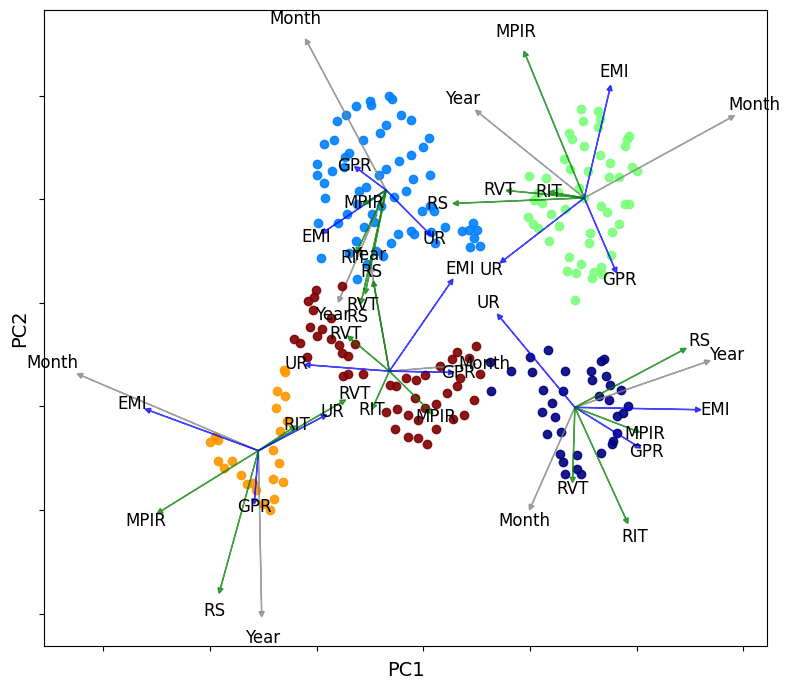

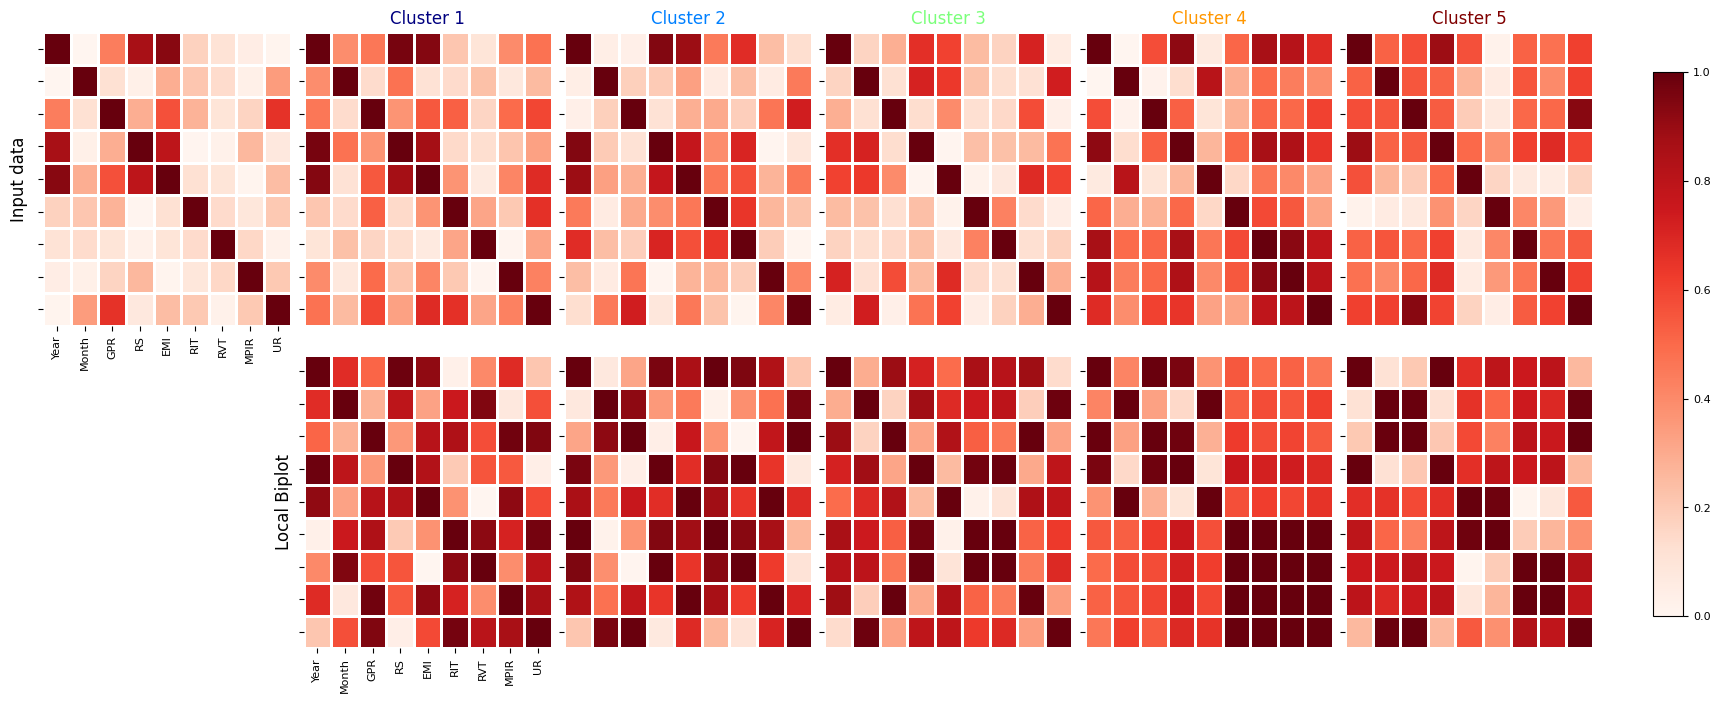

Saving figure classic_bip


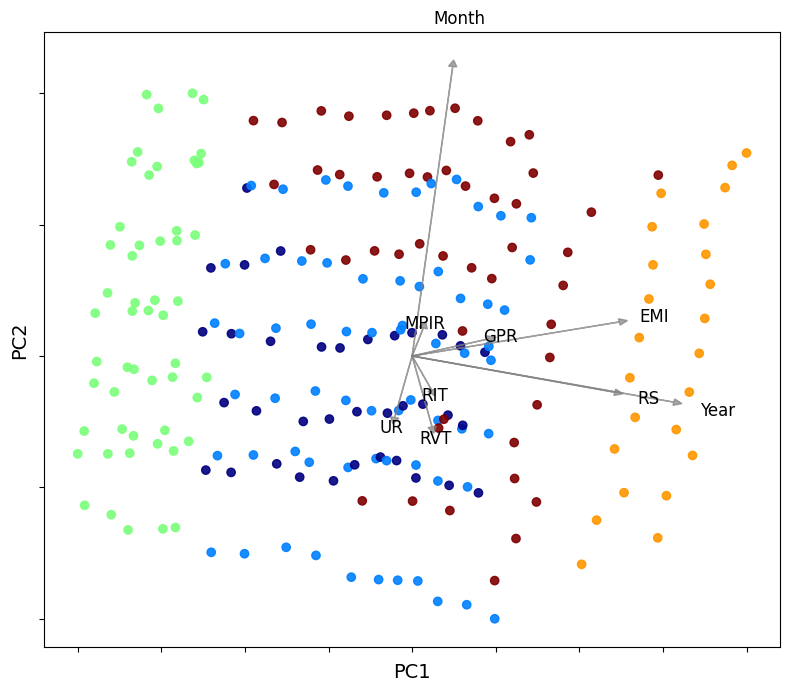

In [16]:
localbiplot = LocalBiplot(affine_='rotation',redm='umap')
#global pca biplot
#loading,rel_,score = localbiplot.biplot2D(Xdata,plot_=True,labels=ydata,loading_labels=Xdata.columns, filename="biplot_classic")
#local biplot
group =localbiplot.local_biplot2D(Xdata,y=5,plot_=True, loading_labels=Xdata.columns,  filename="local_biplot",  use_categories=True)
loading,rel_,score = localbiplot.biplot2D(Xdata,plot_=True,labels=localbiplot.y,loading_labels=Xdata.columns, filename="classic_bip")

#Relevance Graphs

In [17]:

max_val = np.max(rel_)
rel_ = rel_/max_val
relev = pd.DataFrame(rel_.T, index=Xdata.columns)

In [18]:
localbiplot.rel_l.shape
max_val_ = np.max(localbiplot.rel_l)
rel__ = localbiplot.rel_l/max_val_
relev_ = pd.DataFrame(rel__.T, index=Xdata.columns)

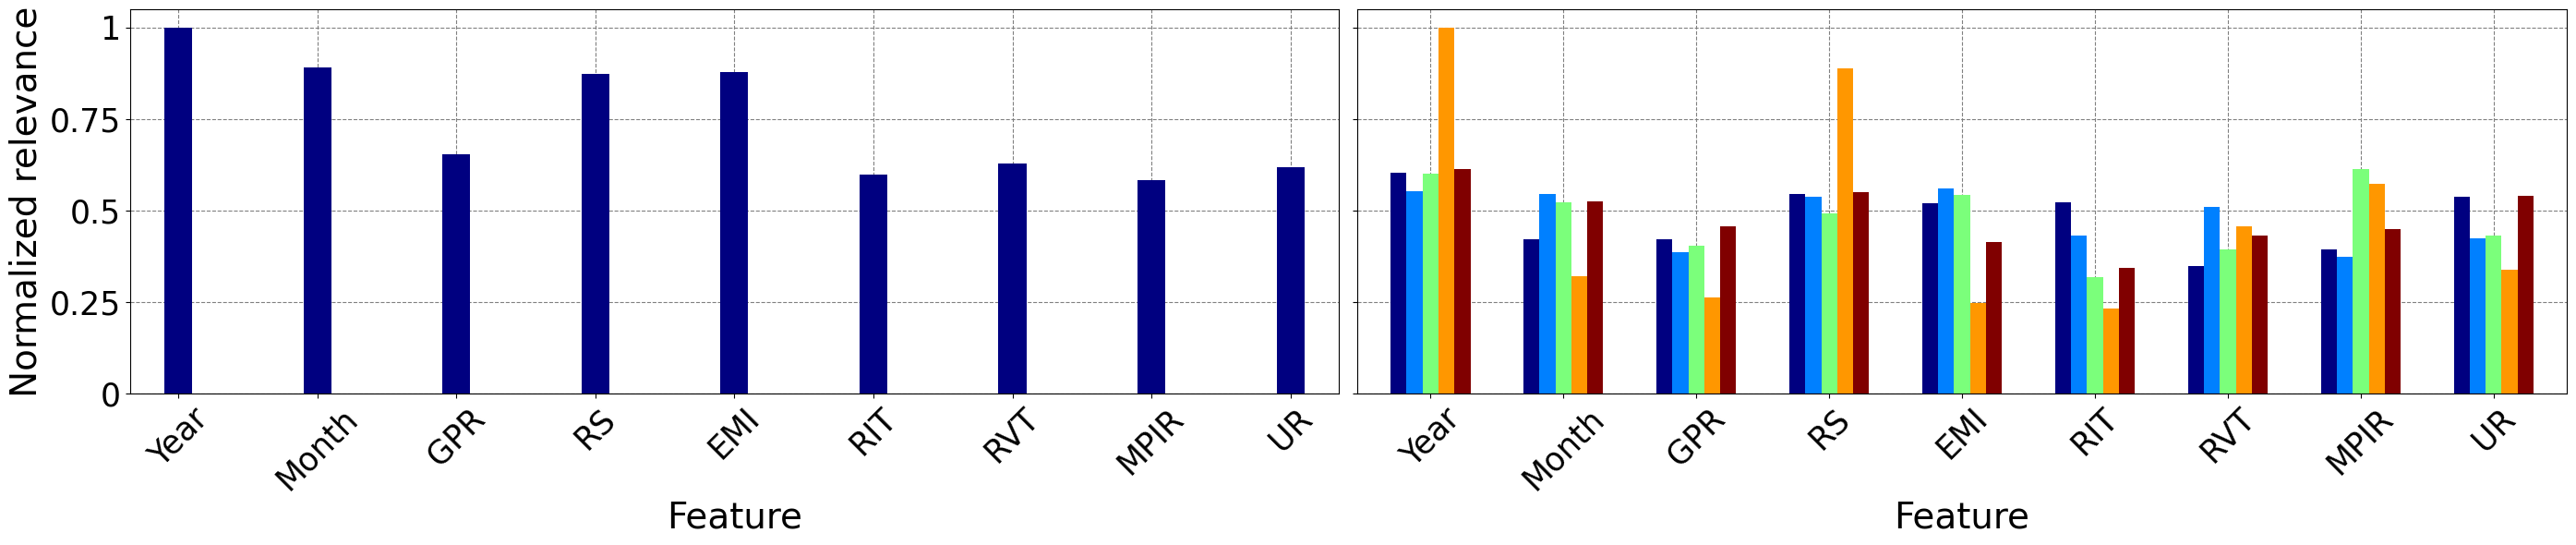

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Asume que 'group' y 'relev' están definidos previamente en tu entorno

# Configuración del colormap
C_ = len(np.unique(group))
cmap_ = mpl.colormaps['jet'].resampled(5)
cmap_ = cmap_(range(5))

# Crear la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 6))

# Gráfica 1
relev.plot.bar(rot=45, ax=ax1, color=cmap_, fontsize=25, legend=False, width=0.2)
ax1.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax1.set_yticklabels(['0','0.25', '0.5', '0.75', '1'])
#ax1.set_xticklabels([])
ax1.set_ylabel("Normalized relevance", fontsize=28)
ax1.set_xlabel("Feature", fontsize=28)
ax1.set_axisbelow(True)
ax1.grid(color='gray', linestyle='dashed')
#ax1.set_title('Gráfica 1')

# Gráfica 2
relev_.plot.bar(rot=45, ax=ax2, color=cmap_, fontsize=25, legend=False, width=0.6)
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1])
#ax1.set_yticklabels(['0','0.25', '0.5', '0.75', '1'])
ax2.set_yticklabels([])
#ax2.set_ylabel("Normalized relevance score", fontsize=22)
ax2.set_axisbelow(True)
ax2.set_xlabel("Feature", fontsize=28)
ax2.grid(color='gray', linestyle='dashed')
#ax2.set_title('Gráfica 2')

# Ajustar el layout para evitar solapamientos
fig.tight_layout()

# Guardar la figura
fig.savefig('combined_plots.pdf', dpi=300)

# Mostrar la figura
plt.show()


In [20]:
def cargar_y_normalizar(archivo, columna=None,s=0):
    df = pd.read_excel(archivo)
    if columna:
        df=pd.DataFrame(np.array(df[columna].apply(lambda x: list(map(float, x.strip('[]').split()))).to_list()))
        a=1/df.mean(axis=0)
        normalizado = abs((a/a.abs().max()))
    elif i==0 or i==3:
        df = df.iloc[:, 1:]  # Seleccionar columnas necesarias cuando no se especifica columna
        normalizado = abs((df.mean(axis=0) / df.mean(axis=0).abs().max()))  # Normalizar
    else:
        df = df.iloc[:, 2:]  # Seleccionar columnas necesarias cuando no se especifica columna
        normalizado = abs((df.mean(axis=0) / df.mean(axis=0).abs().max()))  # Normalizar
    return normalizado.values

In [21]:
b=['GPR-5', 'RS-5', 'EMI-5', 'RIT-5', 'RVT-5', 'MPIR-5', 'UR-5', 'GPR-4',
       'RS-4', 'EMI-4', 'RIT-4', 'RVT-4', 'MPIR-4', 'UR-4', 'GPR-3', 'RS-3',
       'EMI-3', 'RIT-3', 'RVT-3', 'MPIR-3', 'UR-3', 'GPR-2', 'RS-2', 'EMI-2',
       'RIT-2', 'RVT-2', 'MPIR-2', 'UR-2', 'GPR-1', 'RS-1', 'EMI-1', 'RIT-1',
       'RVT-1', 'MPIR-1', 'UR-1', 'GPR', 'RS', 'EMI', 'RIT', 'RVT', 'MPIR']

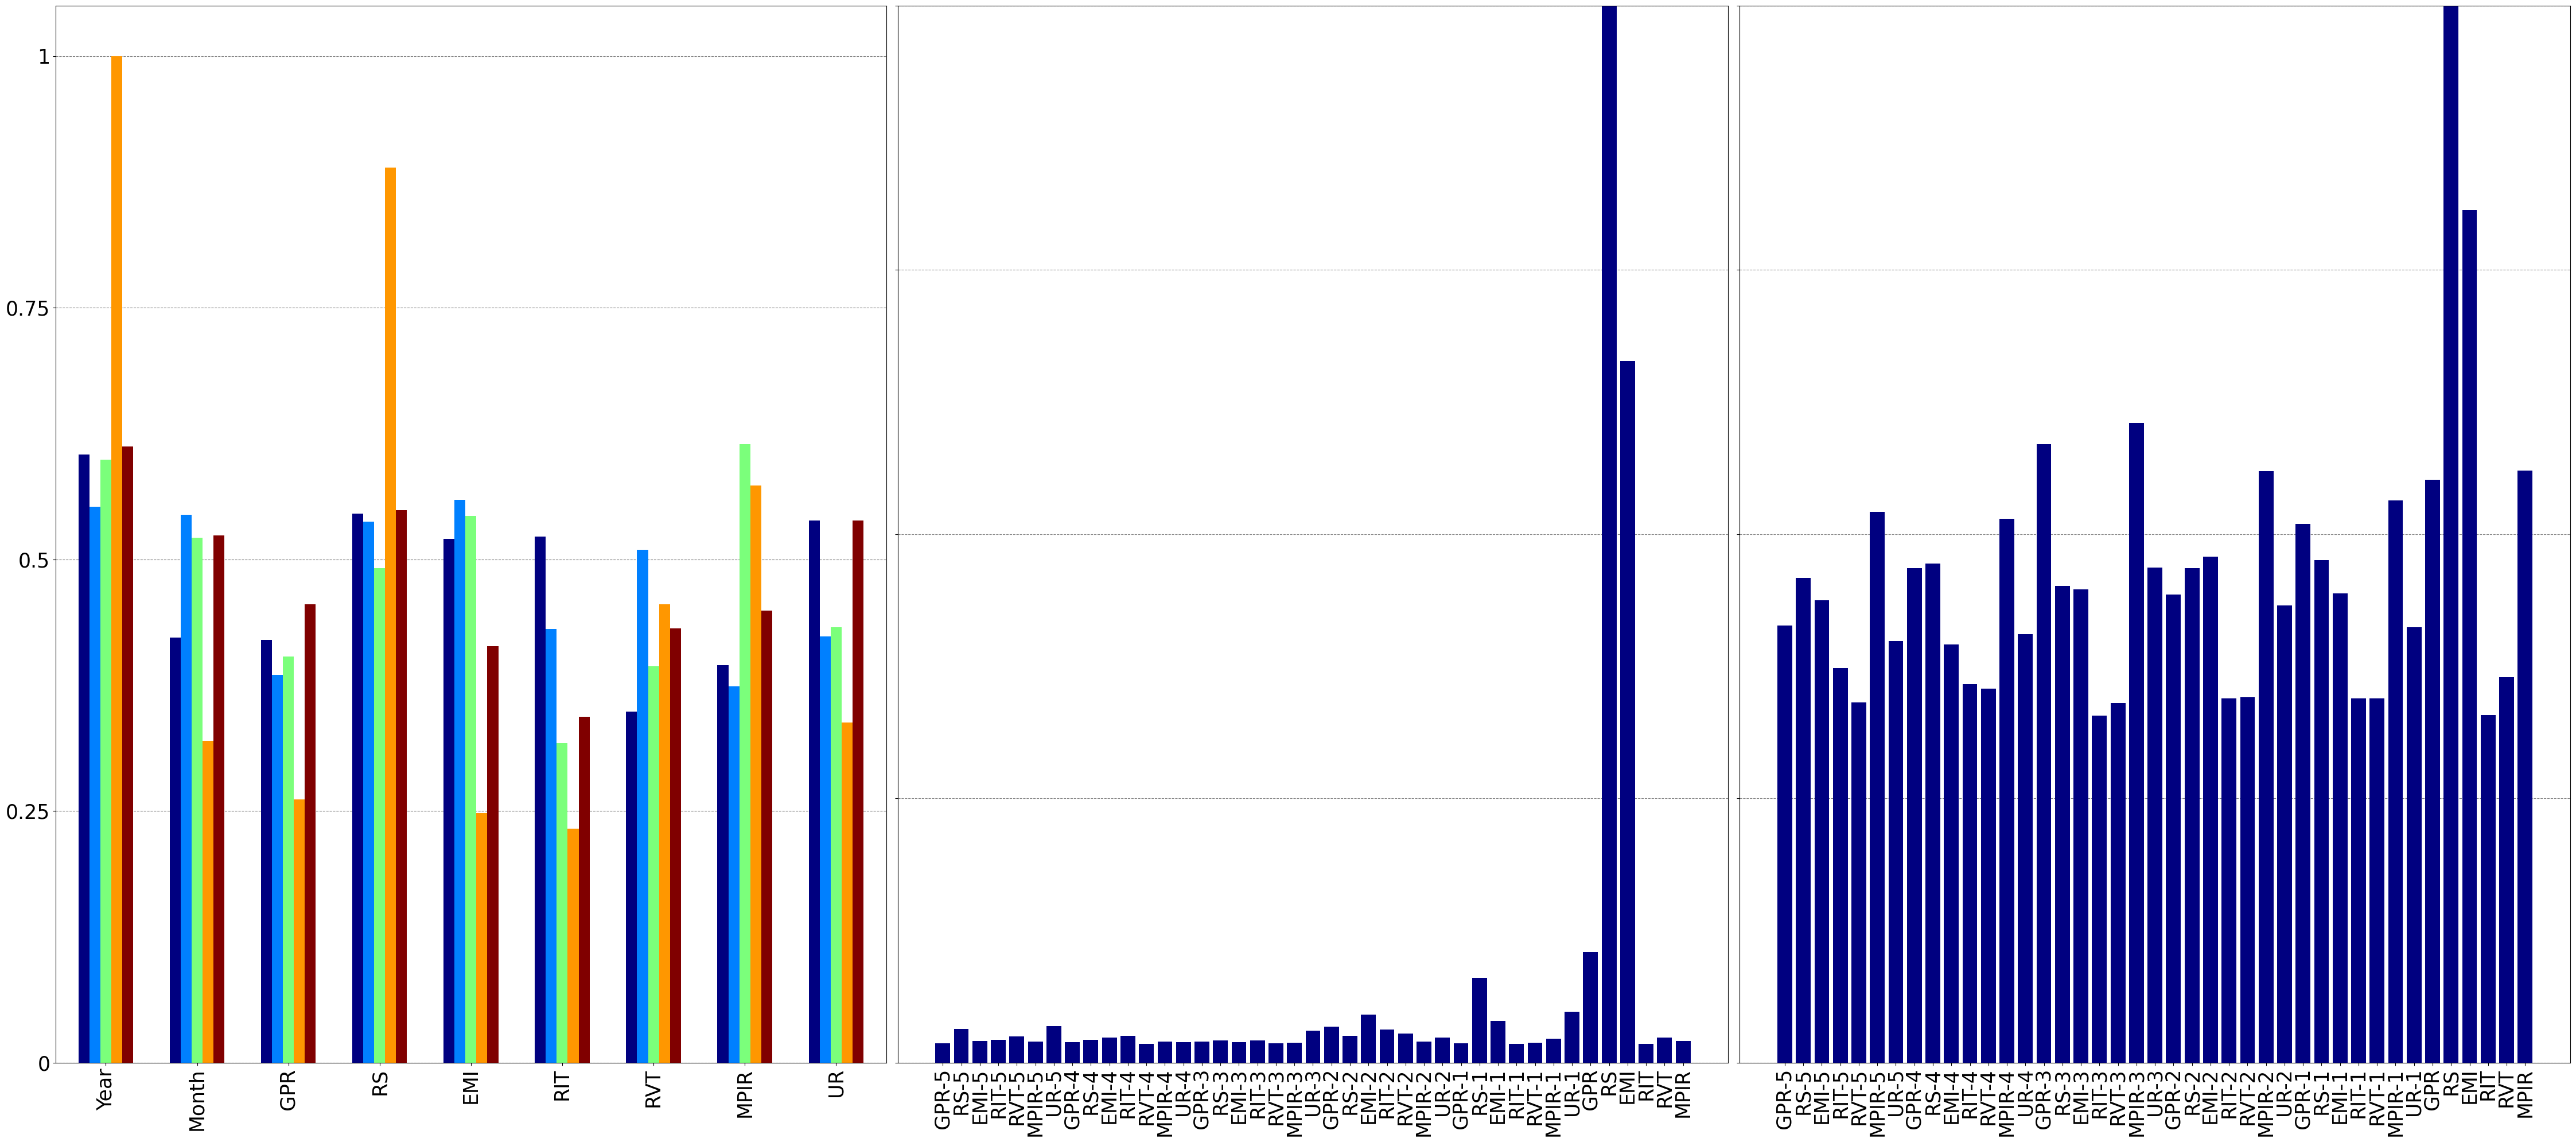

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(45, 20))
# Gráfica 2
relev_.plot.bar(rot=45, ax=ax1, color=cmap_, fontsize=25, legend=False, width=0.6)
ax1.set_xticks(np.arange(len(relev_.index)),labels=relev_.index, rotation=90,fontsize=25)
#ax1.set_yticks([0, 0.25, 0.5, 0.75, 1])
#ax1.set_yticklabels(['0','0.25', '0.5', '0.75', '1'])
#ax1.set_yticklabels([])
#ax2.set_ylabel("Normalized relevance score", fontsize=22)
ax1.set_axisbelow(True)
ax1.grid(axis='y', color='gray', linestyle='dashed')
ax1.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax1.set_yticklabels(['0','0.25', '0.5', '0.75', '1'], fontsize=25)
#ax1.set_xticklabels([])
#ax2.set_title('Gráfica 2')
path='/content/Unemployment-Rate-Prediction/'
i=0
archivo, columna =  (f'{path}3 Meses/Params/GP_0.xlsx', 'length_scale')
normalizado = cargar_y_normalizar(archivo, columna, s=i)
ax2.bar(np.arange(len(b)), normalizado,color=cmap_[0],width=0.8)
# Estas etiquetas se asignan por defecto, pero luego
# las “borramos” según la posición de la celda.
ax2.set_axisbelow(True)
ax2.grid(axis='y', color='gray', linestyle='dashed')
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax2.set_yticklabels([])
ax2.set_ylim(0,1)
ax2.set_xticks(np.arange(len(b)),labels=b, rotation=90,fontsize=25)
i=1
archivo, columna =  (f'{path}3 Meses/Params/GP_1.xlsx', 'length_scale')
normalizado = cargar_y_normalizar(archivo, columna, s=i)
ax3.bar(np.arange(len(b)), normalizado,color=cmap_[0],width=0.8)
# Estas etiquetas se asignan por defecto, pero luego
# las “borramos” según la posición de la celda.
ax3.set_axisbelow(True)
ax3.grid(axis='y', color='gray', linestyle='dashed')
ax3.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax3.set_yticklabels([])
ax3.set_ylim(0,1)
ax3.set_xticks(np.arange(len(b)),labels=b, rotation=90,fontsize=25)

plt.tight_layout()
fig.savefig('3MergeC.pdf')
plt.show()

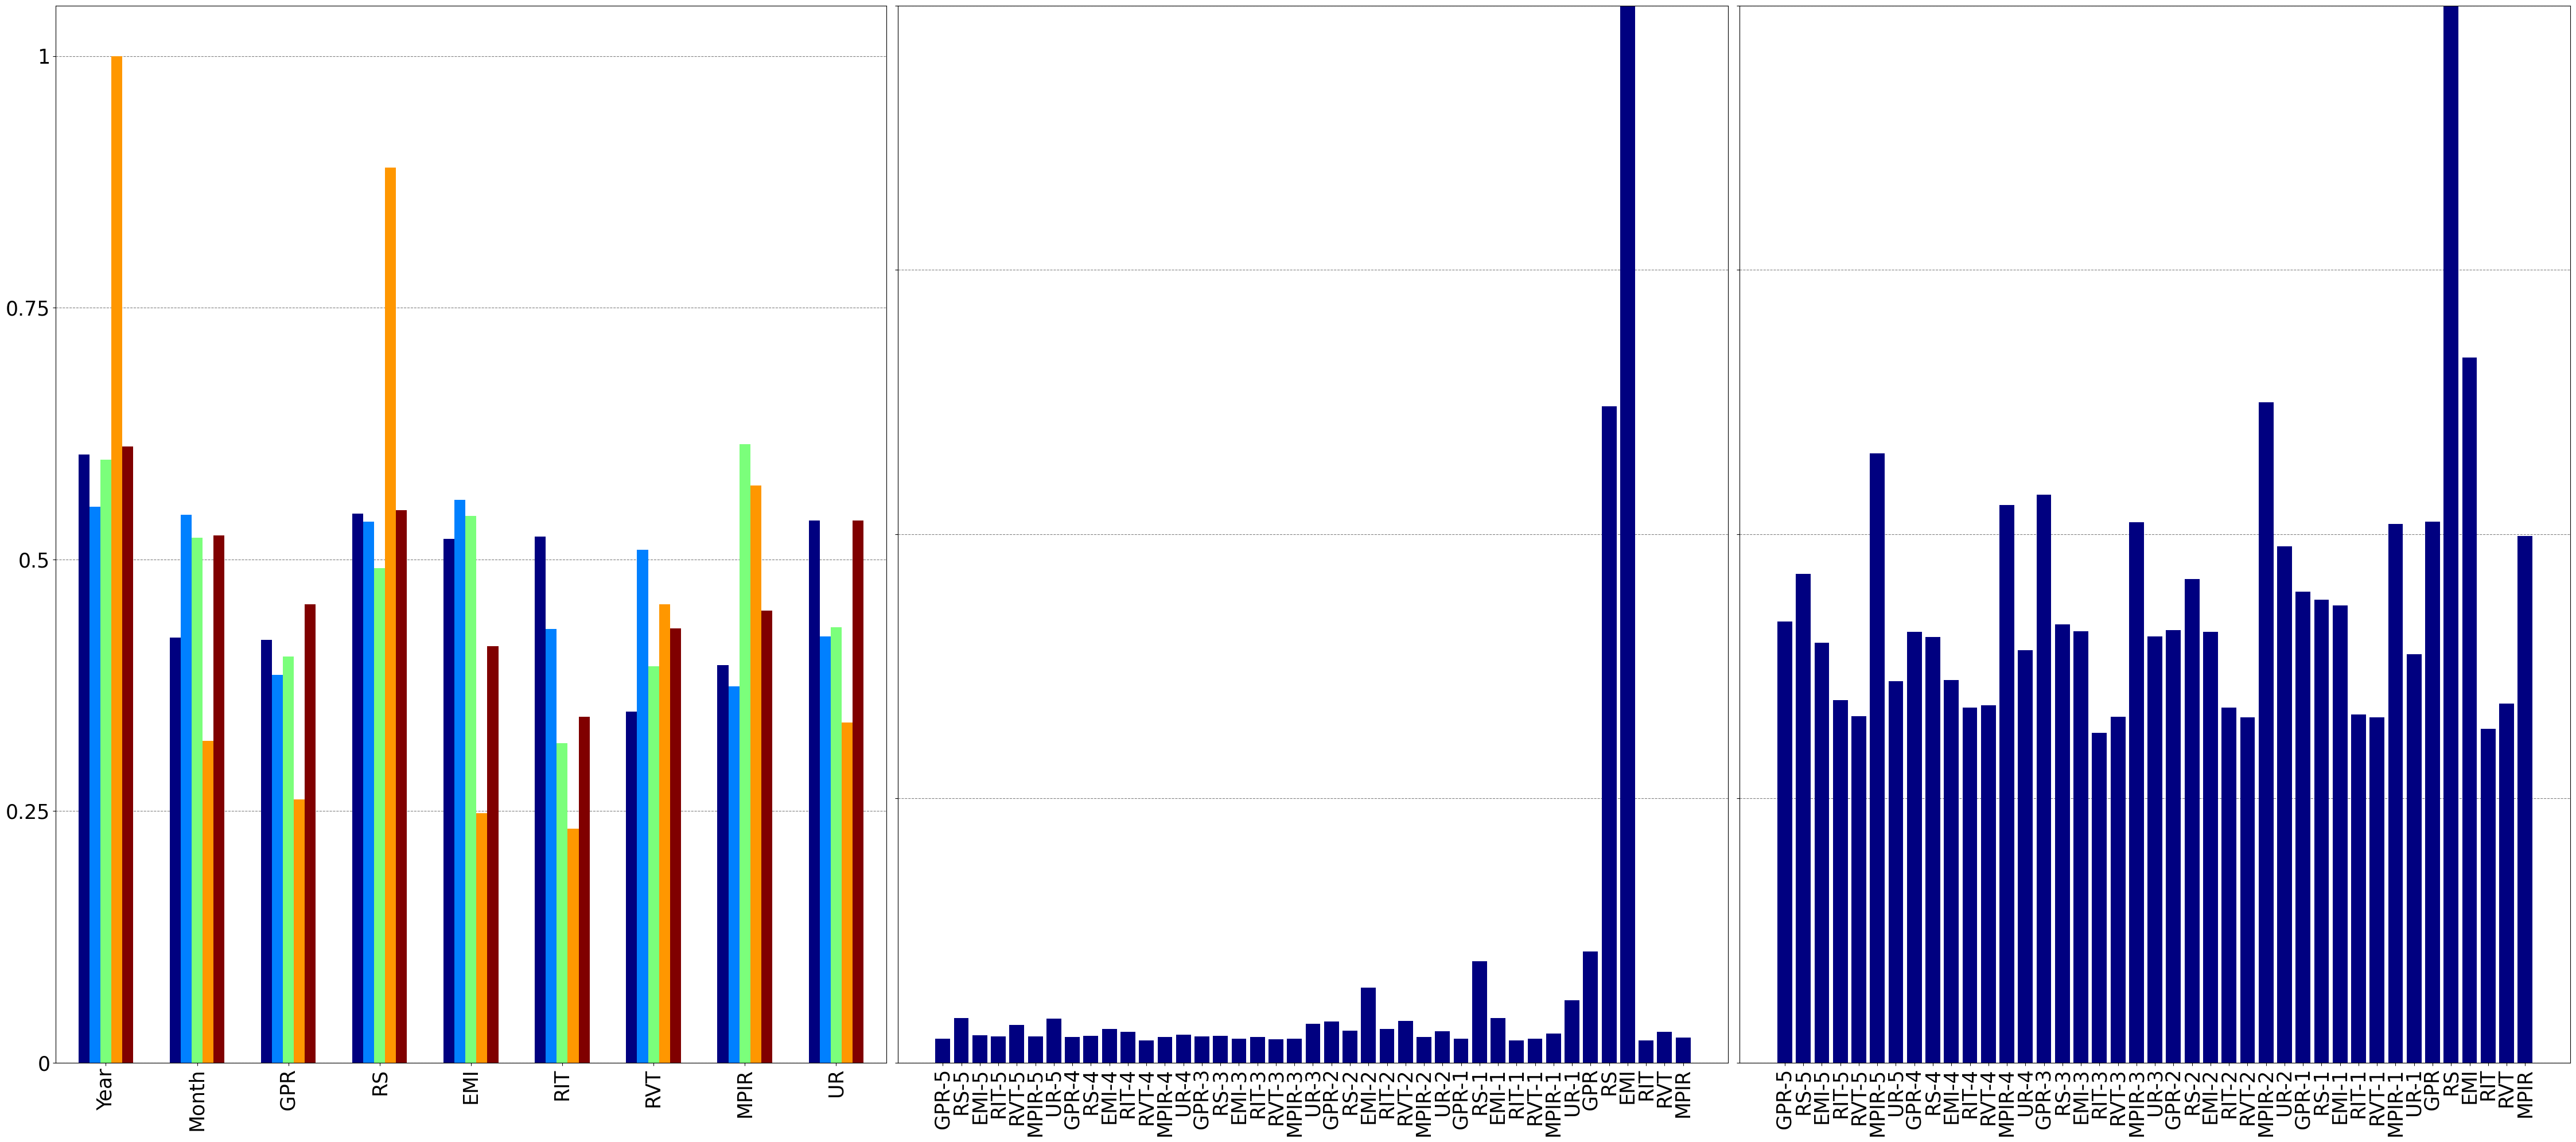

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(45, 20))
# Gráfica 2
relev_.plot.bar(rot=45, ax=ax1, color=cmap_, fontsize=25, legend=False, width=0.6)
ax1.set_xticks(np.arange(len(relev_.index)),labels=relev_.index, rotation=90,fontsize=25)
#ax1.set_yticks([0, 0.25, 0.5, 0.75, 1])
#ax1.set_yticklabels(['0','0.25', '0.5', '0.75', '1'])
#ax1.set_yticklabels([])
#ax2.set_ylabel("Normalized relevance score", fontsize=22)
ax1.set_axisbelow(True)
ax1.grid(axis='y', color='gray', linestyle='dashed')
ax1.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax1.set_yticklabels(['0','0.25', '0.5', '0.75', '1'], fontsize=25)
#ax1.set_xticklabels([])
#ax2.set_title('Gráfica 2')

archivo, columna =  (f'{path}12 Meses/Params/GP_0.xlsx', 'length_scale')
i=0
normalizado = cargar_y_normalizar(archivo, columna, s=i)
ax2.bar(np.arange(len(b)), normalizado,color=cmap_[0],width=0.8)
# Estas etiquetas se asignan por defecto, pero luego
# las “borramos” según la posición de la celda.
ax2.set_axisbelow(True)
ax2.grid(axis='y', color='gray', linestyle='dashed')
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax2.set_yticklabels([])
ax2.set_ylim(0,1)
ax2.set_xticks(np.arange(len(b)),labels=b, rotation=90,fontsize=25)
i=1
archivo, columna =  (f'{path}12 Meses/Params/GP_1.xlsx', 'length_scale')
normalizado = cargar_y_normalizar(archivo, columna, s=i)
ax3.bar(np.arange(len(b)), normalizado,color=cmap_[0],width=0.8)
# Estas etiquetas se asignan por defecto, pero luego
# las “borramos” según la posición de la celda.
ax3.set_axisbelow(True)
ax3.grid(axis='y', color='gray', linestyle='dashed')
ax3.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax3.set_yticklabels([])
ax3.set_ylim(0,1)
ax3.set_xticks(np.arange(len(b)),labels=b, rotation=90,fontsize=25)

plt.tight_layout()
fig.savefig('12MergeC.pdf')
plt.show()

#Correlations

Performing clustering...
(228,) - [0 1 2 3]
Affine Transformation...
1/4
[0.355 0.431 0.727 0.215 0.733 0.173 0.422 0.293]
2/4
[0.092 0.459 0.717 0.12  0.446 0.232 0.002 0.419]
3/4
[0.056 0.732 0.036 0.47  0.609 0.048 0.175 0.291]
4/4
[0.095 0.363 0.93  0.17  0.675 0.008 0.427 0.527]


<Figure size 640x480 with 0 Axes>

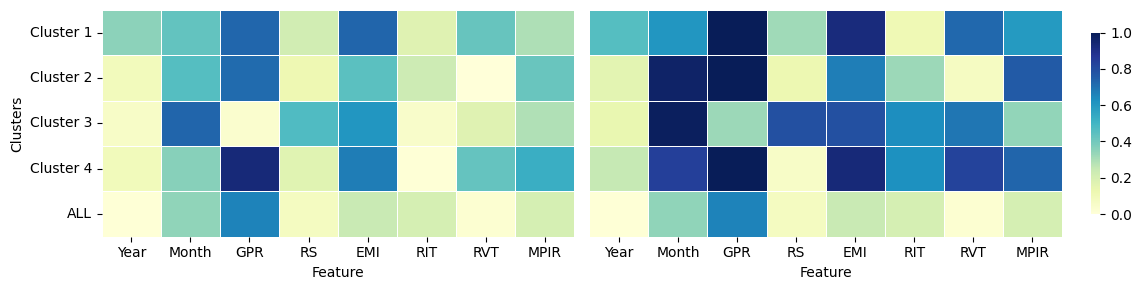

In [24]:
localbiplot.correlations_by_target(data=data,X=Xdata,y=4,loading_labels=Xdata.columns, filename='ECO', key='UR')


#Adding  column Terms to Dataframe


In [25]:

# Definir la función para asignar periodos
def asignar_periodo(año):
    if año == 2005:
        return 'IT'
    elif 2006 <= año <= 2010:
        return 'GT 1'
    elif 2010 < año <= 2014:
        return 'GT 2'
    elif 2014 < año <= 2018:
        return 'GT 3'
    elif 2018 < año <= 2022:
        return 'GT 4'
    elif año == 2023:
        return 'FT'
    else:
        return 'Fuera de rango'

# Añadir la columna "Periodos"
Xdata['Terms'] = Xdata['Year'].apply(asignar_periodo)


# KDE PLOT


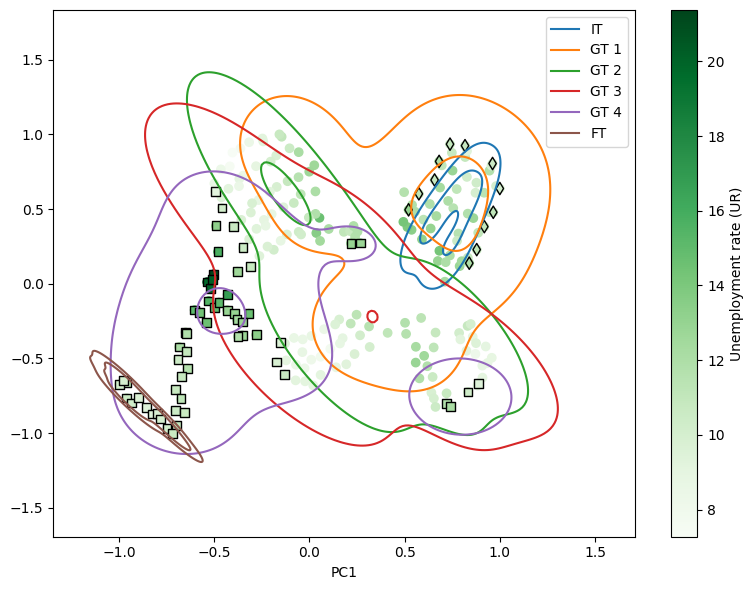

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import kdeplot

# Obtener el colormap usado y los límites
cmap = plt.get_cmap('Greens')
norm = plt.Normalize(vmin=Xdata['UR'].min(), vmax=Xdata['UR'].max())

# Filtrar los datos de la crisis 2008 (año 2008)
crisis_2008 = (Xdata['Year'] == 2008)

# Filtrar los datos del COVID-19 (años 2019 a 2023)
covid_19 = (Xdata['Year'] >= 2019) & (Xdata['Year'] <= 2023)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

dataZ = pd.DataFrame(localbiplot.Zr, columns=['PC1', 'PC2'])

# KDE plot
kdeplot(data=dataZ, x='PC1', y='PC2', hue=Xdata['Terms'].values, ax=ax, levels=3)

# Scatter plot con color por 'UR'
scatter = ax.scatter(dataZ['PC1'], dataZ['PC2'], c=Xdata['UR'], cmap='Greens')

# Agregar puntos de la crisis 2008 con el mismo color basado en 'UR'
ax.scatter(dataZ.loc[crisis_2008, 'PC1'], dataZ.loc[crisis_2008, 'PC2'],
           c=cmap(norm(Xdata.loc[crisis_2008, 'UR'])), cmap='Greens', marker='d', edgecolor='k', s=40)

# Agregar puntos de la pandemia COVID-19 con el mismo color basado en 'UR'
ax.scatter(dataZ.loc[covid_19, 'PC1'], dataZ.loc[covid_19, 'PC2'],
           c=cmap(norm(Xdata.loc[covid_19, 'UR'])), cmap='Greens', marker='s', edgecolor='k', s=40,)

# Añadir colorbar con la etiqueta 'UR'
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Unemployment rate (UR)')

# Eliminar etiquetas de los ejes
#ax.set_xticklabels([])
#ax.set_yticklabels([])
ax.set_ylabel('')  # Eliminar etiqueta 'PC2'

# Añadir leyenda
#ax.legend()

# Guardar y mostrar la figura
fig.savefig('KDE.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()


#  Terms variable categorical to int

In [27]:
mapping = {

    'IT': 0,
    'GT 1': 1,
    'GT 2': 2,
    'GT 3': 3,
    'GT 4': 4,
    'FT': 5
}

Xdata['Terms'].replace(mapping, inplace=True)

In [28]:
#preiodos de gobierno: 2005: A.U , 2006-2010 A.U , 2010-2014 J.M.S, 2014-2018   J.M.S  2018-2022 I.D  final:2023 G.P
#
#analisis de colas

In [29]:
data['Terms'] = Xdata['Terms']

# Silhouette score


In [30]:
from sklearn.metrics import silhouette_score


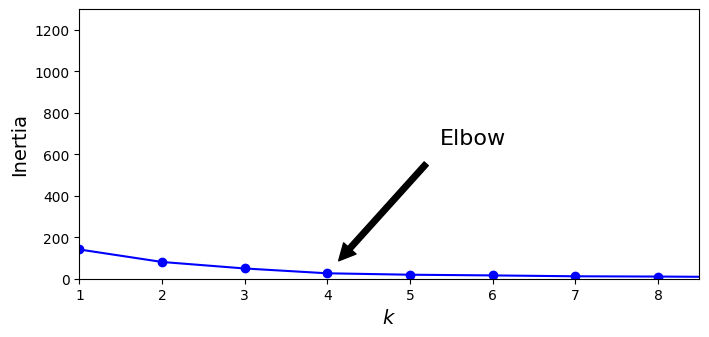

In [31]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(localbiplot.Zr)
                for k in range(1, 10)]
inertias     = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
#save_fig("inertia_vs_k_plot")
plt.show()

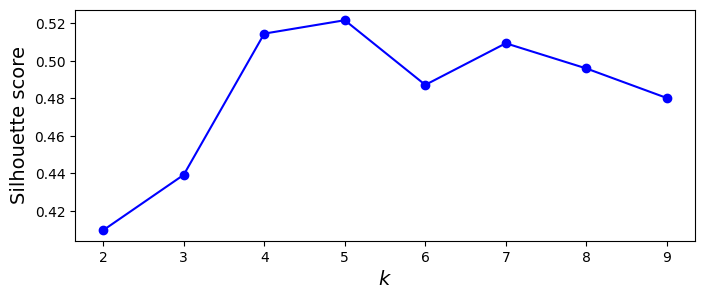

In [32]:
silhouette_scores = [silhouette_score(localbiplot.Zr, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7])
#save_fig("silhouette_score_vs_k_plot")
plt.show()

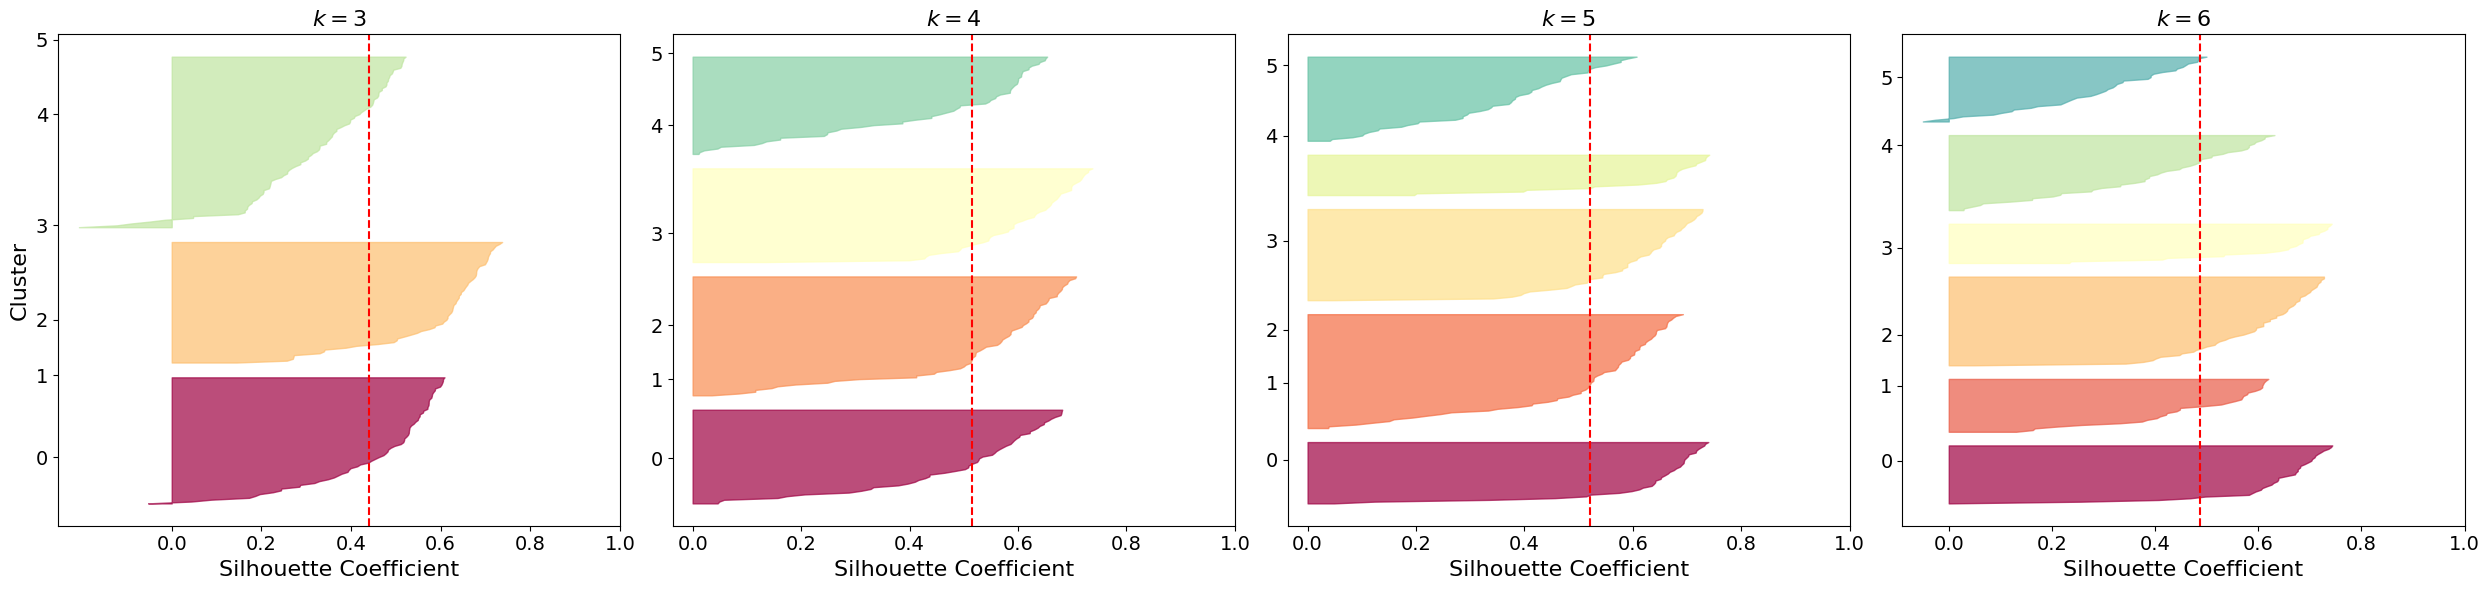

In [33]:
import matplotlib as mpl
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(25, 6))

for k in (3, 4, 5, 6):
    plt.subplot(1, 4, k - 2)

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(localbiplot.Zr, y_pred)

    padding = len(localbiplot.Zr) // 30
    pos     = padding
    ticks   = [32, 76, 106, 157, 217, 257]
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        #ticks.append(pos + len(coeffs) // 2)
       # print(ticks)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(7)))


    # Establece el eje Y entre 0 y 5 de forma fija
    #plt.ylim(0, 5)  # Esto elimina la autoescala del eje Y y lo fija entre 0 y 5

    if k == 3:
        plt.ylabel("Cluster", fontsize=16)

    plt.gca().set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Silhouette Coefficient", fontsize=16)
    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.savefig('silhouette_analysis_plot.pdf', format='pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()


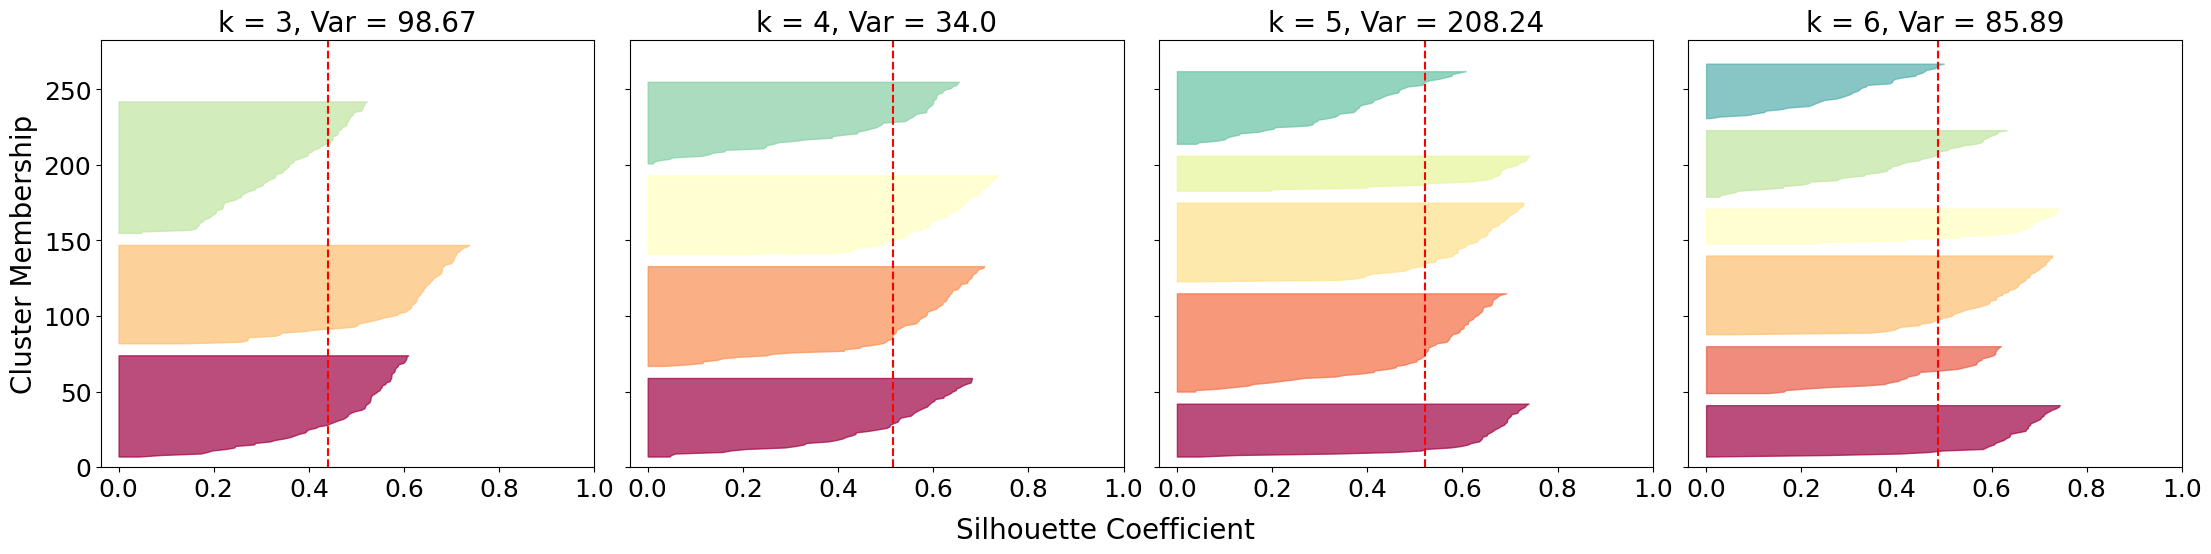

In [34]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples
import numpy as np

# Determina el rango máximo del eje y
y_max = 0
for k in range(3, 7):
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(localbiplot.Zr, y_pred)
    y_max = max(y_max, len(silhouette_coefficients))

# Crea la figura con layout restringido
fig, axes = plt.subplots(1, 4, figsize=(22, 5), constrained_layout=True)

for idx, k in enumerate(range(3, 7)):
    ax = axes[idx]

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(localbiplot.Zr, y_pred)

    padding = len(localbiplot.Zr) // 30
    pos = padding
    ticks = []
    aux = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs = coeffs[coeffs > 0]
        aux.append(len(coeffs))
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        y_positions = np.arange(pos, pos + len(coeffs))
        ax.fill_betweenx(y_positions, 0, coeffs,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    # Añade las etiquetas del eje x e y solo al primer subplot
    if idx == 0:
        ax.set_ylabel("Cluster Membership", fontsize=20)
    #ax.set_xlabel("Silhouette Coefficient", fontsize=16)

    ax.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    ax.set_title(f"k = {k}, Var = {round(np.array(aux).var(), 2)}", fontsize=20)

    # Alineación de ejes y ticks
    ax.set_ylim(0, y_max+55)

    # Solo el primer subplot tendrá los ticks labels
    if idx != 0:
        plt.setp(ax.get_yticklabels(), visible=False)
       #plt.setp(ax.get_xticklabels(), visible=False)

    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.tick_params(axis='both', which='major', labelsize=18)

# Añade un label común para el eje x y el eje y
fig.text(0.5, -0.05, 'Silhouette Coefficient', ha='center', va='center', fontsize=20)
#fig.text(0.06, 0.5, 'Cluster', ha='center', va='center', rotation='vertical', fontsize=16)

plt.savefig('silhouette_analysis_plot.pdf', format='pdf', bbox_inches='tight')
plt.show()


#LOCAL BIPLOT POR PERIODOS PRESIDENCIALES

In [35]:
Terms = Xdata['Terms']
Terms.values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5])

In [36]:
Xdata = Xdata.iloc[:,:-1]

In [37]:
localbiplotT = LocalBiplot(affine_='rotation',redm='umap')

Dimensionality Reduction...
Affine Transformation...
1/6
(12, 9)
plot 1-th group
Saving figure local_biplot_Terms
2/6
(60, 9)
plot 2-th group
Saving figure local_biplot_Terms
3/6
(48, 9)
plot 3-th group
Saving figure local_biplot_Terms
4/6
(48, 9)
plot 4-th group
Saving figure local_biplot_Terms
5/6
(48, 9)
plot 5-th group
Saving figure local_biplot_Terms
6/6
(12, 9)
plot 6-th group
Saving figure local_biplot_Terms


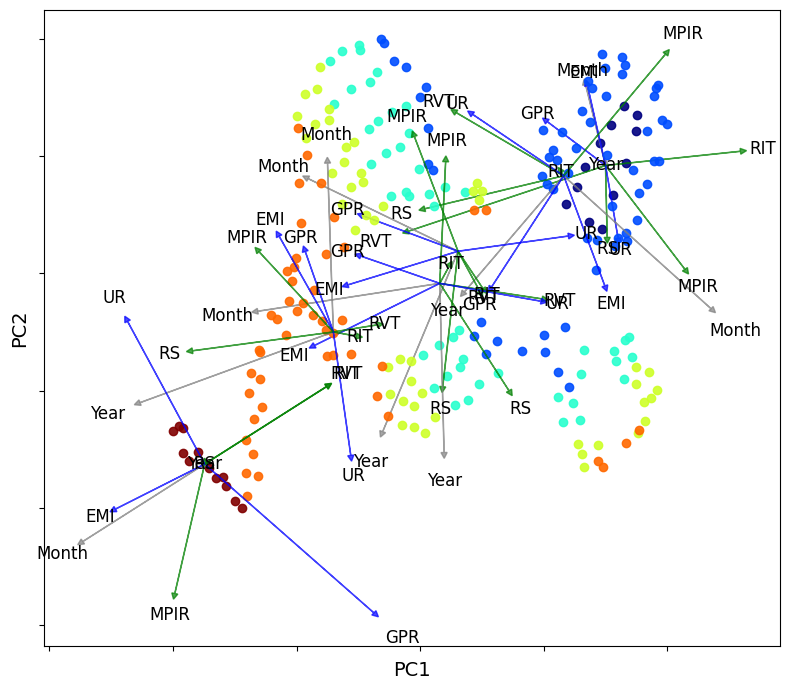

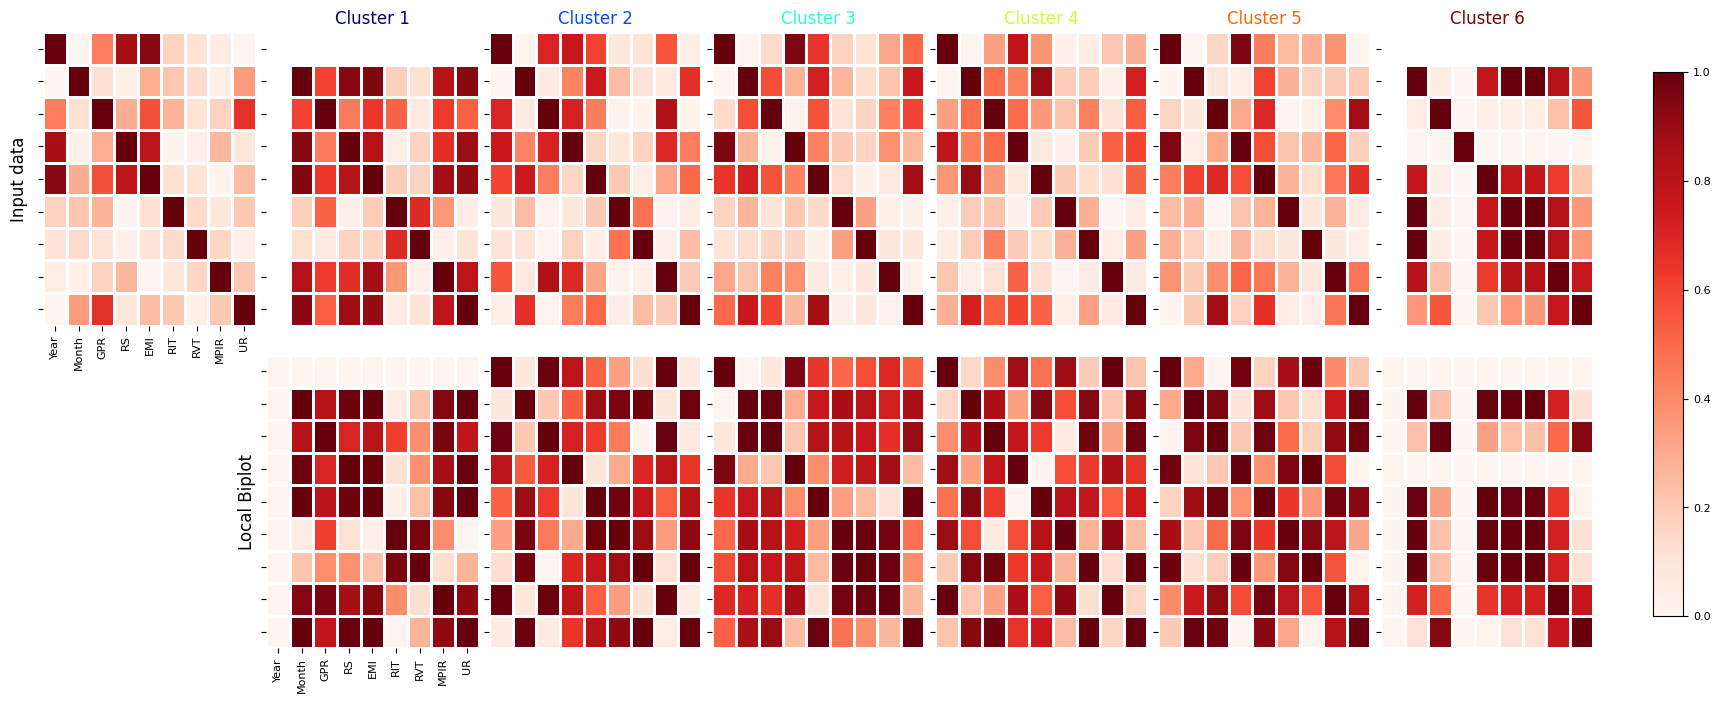

Saving figure classic_bip_Terms


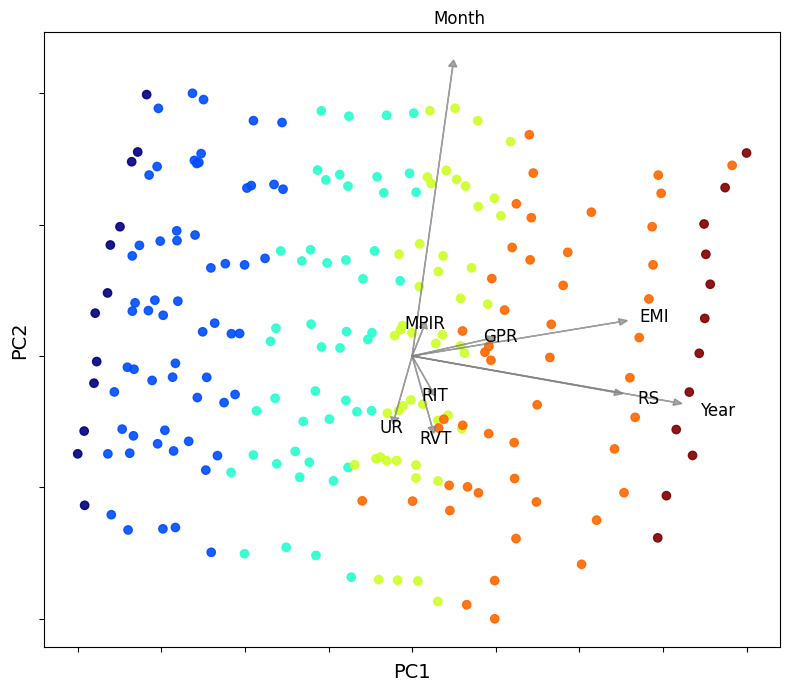

In [38]:
group =localbiplotT.local_biplot2D(Xdata,y= Terms.values,plot_=True, loading_labels=Xdata.columns,  filename="local_biplot_Terms",  use_categories=True)
loading,rel_,score = localbiplotT.biplot2D(Xdata,plot_=True,labels=localbiplotT.y,loading_labels=Xdata.columns, filename="classic_bip_Terms")

In [39]:
len(np.unique(group))

6

In [40]:
Xdata.columns

Index(['Year', 'Month', 'GPR', 'RS', 'EMI', 'RIT', 'RVT', 'MPIR', 'UR'], dtype='object')

In [41]:
localbiplotT.rel_l.shape
max_val_ = np.max(localbiplot.rel_l)
rel__ = localbiplotT.rel_l/max_val_
relev_ = pd.DataFrame(rel__.T, index=Xdata.columns)

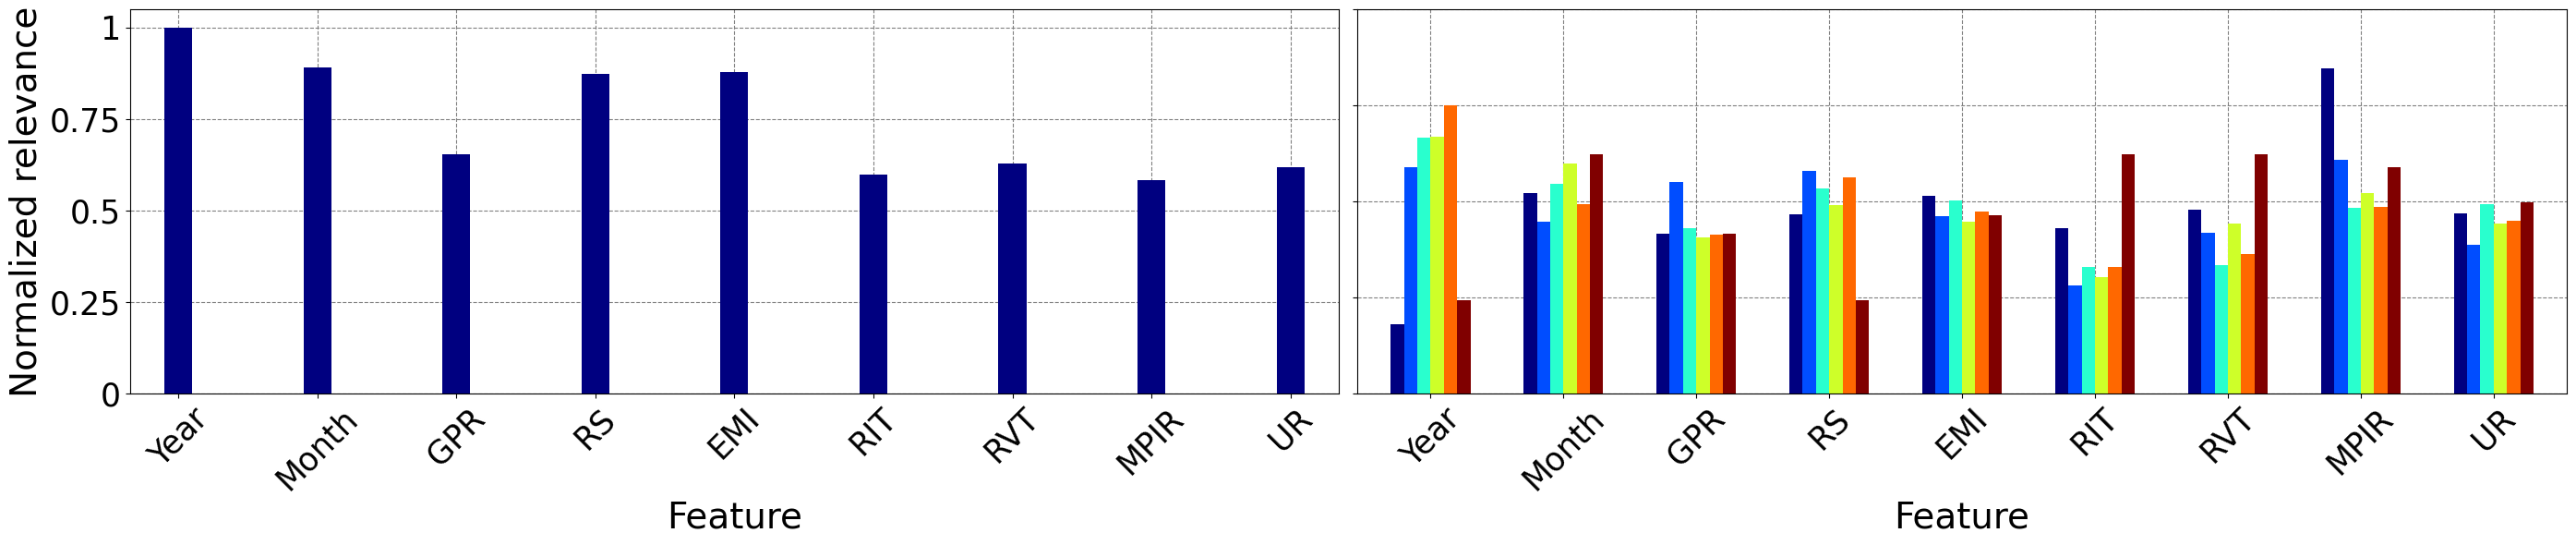

In [42]:

max_val = np.max(rel_)
rel_ = rel_/max_val
relev = pd.DataFrame(rel_.T, index=Xdata.columns)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Asume que 'group' y 'relev' están definidos previamente en tu entorno

# Configuración del colormap
C_ = len(np.unique(group))
cmap_ = mpl.colormaps['jet'].resampled(C_ )
cmap_ = cmap_(range(C_ ))

# Crear la figura y los subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 6))

# Gráfica 1
relev.plot.bar(rot=45, ax=ax1, color=cmap_, fontsize=25, legend=False, width=0.2)
ax1.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax1.set_yticklabels(['0','0.25', '0.5', '0.75', '1'])
#ax1.set_xticklabels([])
ax1.set_ylabel("Normalized relevance", fontsize=28)
ax1.set_xlabel("Feature", fontsize=28)
ax1.set_axisbelow(True)
ax1.grid(color='gray', linestyle='dashed')
#ax1.set_title('Gráfica 1')

# Gráfica 2
relev_.plot.bar(rot=45, ax=ax2, color=cmap_, fontsize=25, legend=False, width=0.6)
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1])
#ax1.set_yticklabels(['0','0.25', '0.5', '0.75', '1'])
ax2.set_yticklabels([])
#ax2.set_ylabel("Normalized relevance score", fontsize=22)
ax2.set_axisbelow(True)
ax2.set_xlabel("Feature", fontsize=28)
ax2.grid(color='gray', linestyle='dashed')
#ax2.set_title('Gráfica 2')

# Ajustar el layout para evitar solapamientos
fig.tight_layout()

# Guardar la figura
fig.savefig('combined_plots_terms.pdf', dpi=300)

# Mostrar la figura
plt.show()


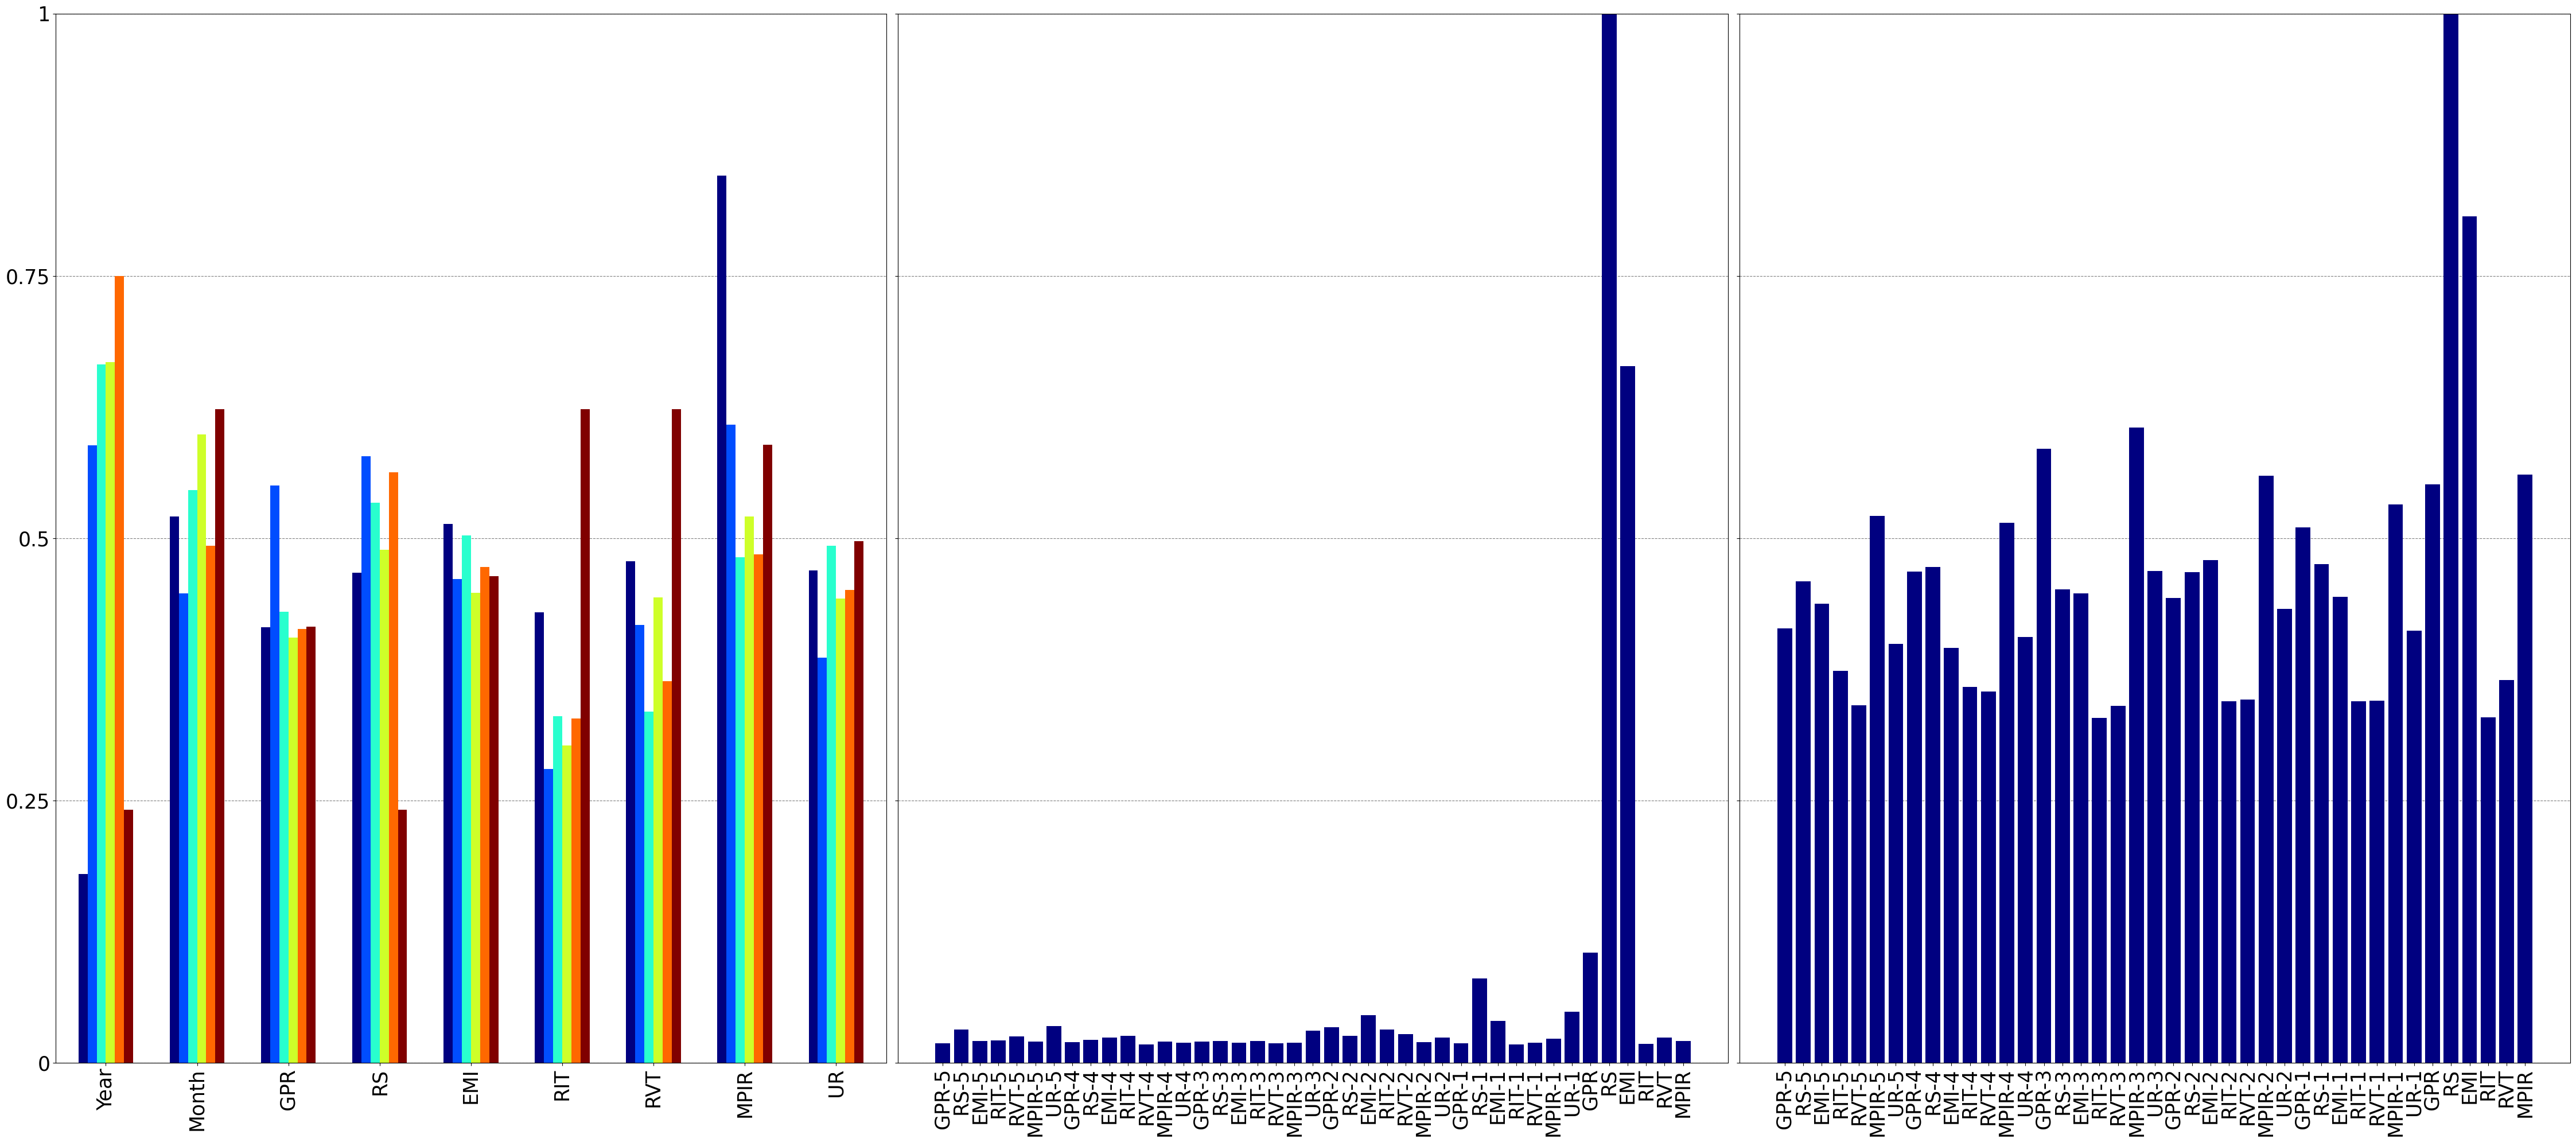

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(45, 20))
# Gráfica 2
relev_.plot.bar(rot=45, ax=ax1, color=cmap_, fontsize=25, legend=False, width=0.6)
ax1.set_xticks(np.arange(len(relev_.index)),labels=relev_.index, rotation=90,fontsize=25)
#ax1.set_yticks([0, 0.25, 0.5, 0.75, 1])
#ax1.set_yticklabels(['0','0.25', '0.5', '0.75', '1'])
#ax1.set_yticklabels([])
#ax2.set_ylabel("Normalized relevance score", fontsize=22)
ax1.set_axisbelow(True)
ax1.grid(axis='y', color='gray', linestyle='dashed')
ax1.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax1.set_yticklabels(['0','0.25', '0.5', '0.75', '1'], fontsize=25)
#ax1.set_xticklabels([])
#ax2.set_title('Gráfica 2')
i=0
archivo, columna =  (f'{path}3 Meses/Params/GP_0.xlsx', 'length_scale')
normalizado = cargar_y_normalizar(archivo, columna, s=i)
ax2.bar(np.arange(len(b)), normalizado,color=cmap_[0],width=0.8)
# Estas etiquetas se asignan por defecto, pero luego
# las “borramos” según la posición de la celda.
ax2.set_axisbelow(True)
ax2.grid(axis='y', color='gray', linestyle='dashed')
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax2.set_yticklabels([])
ax2.set_ylim(0,1)
ax2.set_xticks(np.arange(len(b)),labels=b, rotation=90,fontsize=25)
i=1
archivo, columna =  (f'{path}3 Meses/Params/GP_1.xlsx', 'length_scale')
normalizado = cargar_y_normalizar(archivo, columna, s=i)
ax3.bar(np.arange(len(b)), normalizado,color=cmap_[0],width=0.8)
# Estas etiquetas se asignan por defecto, pero luego
# las “borramos” según la posición de la celda.
ax3.set_axisbelow(True)
ax3.grid(axis='y', color='gray', linestyle='dashed')
ax3.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax3.set_yticklabels([])
ax3.set_ylim(0,1)
ax3.set_xticks(np.arange(len(b)),labels=b, rotation=90,fontsize=25)
plt.tight_layout()
fig.savefig('3MergeG.pdf')
plt.show()

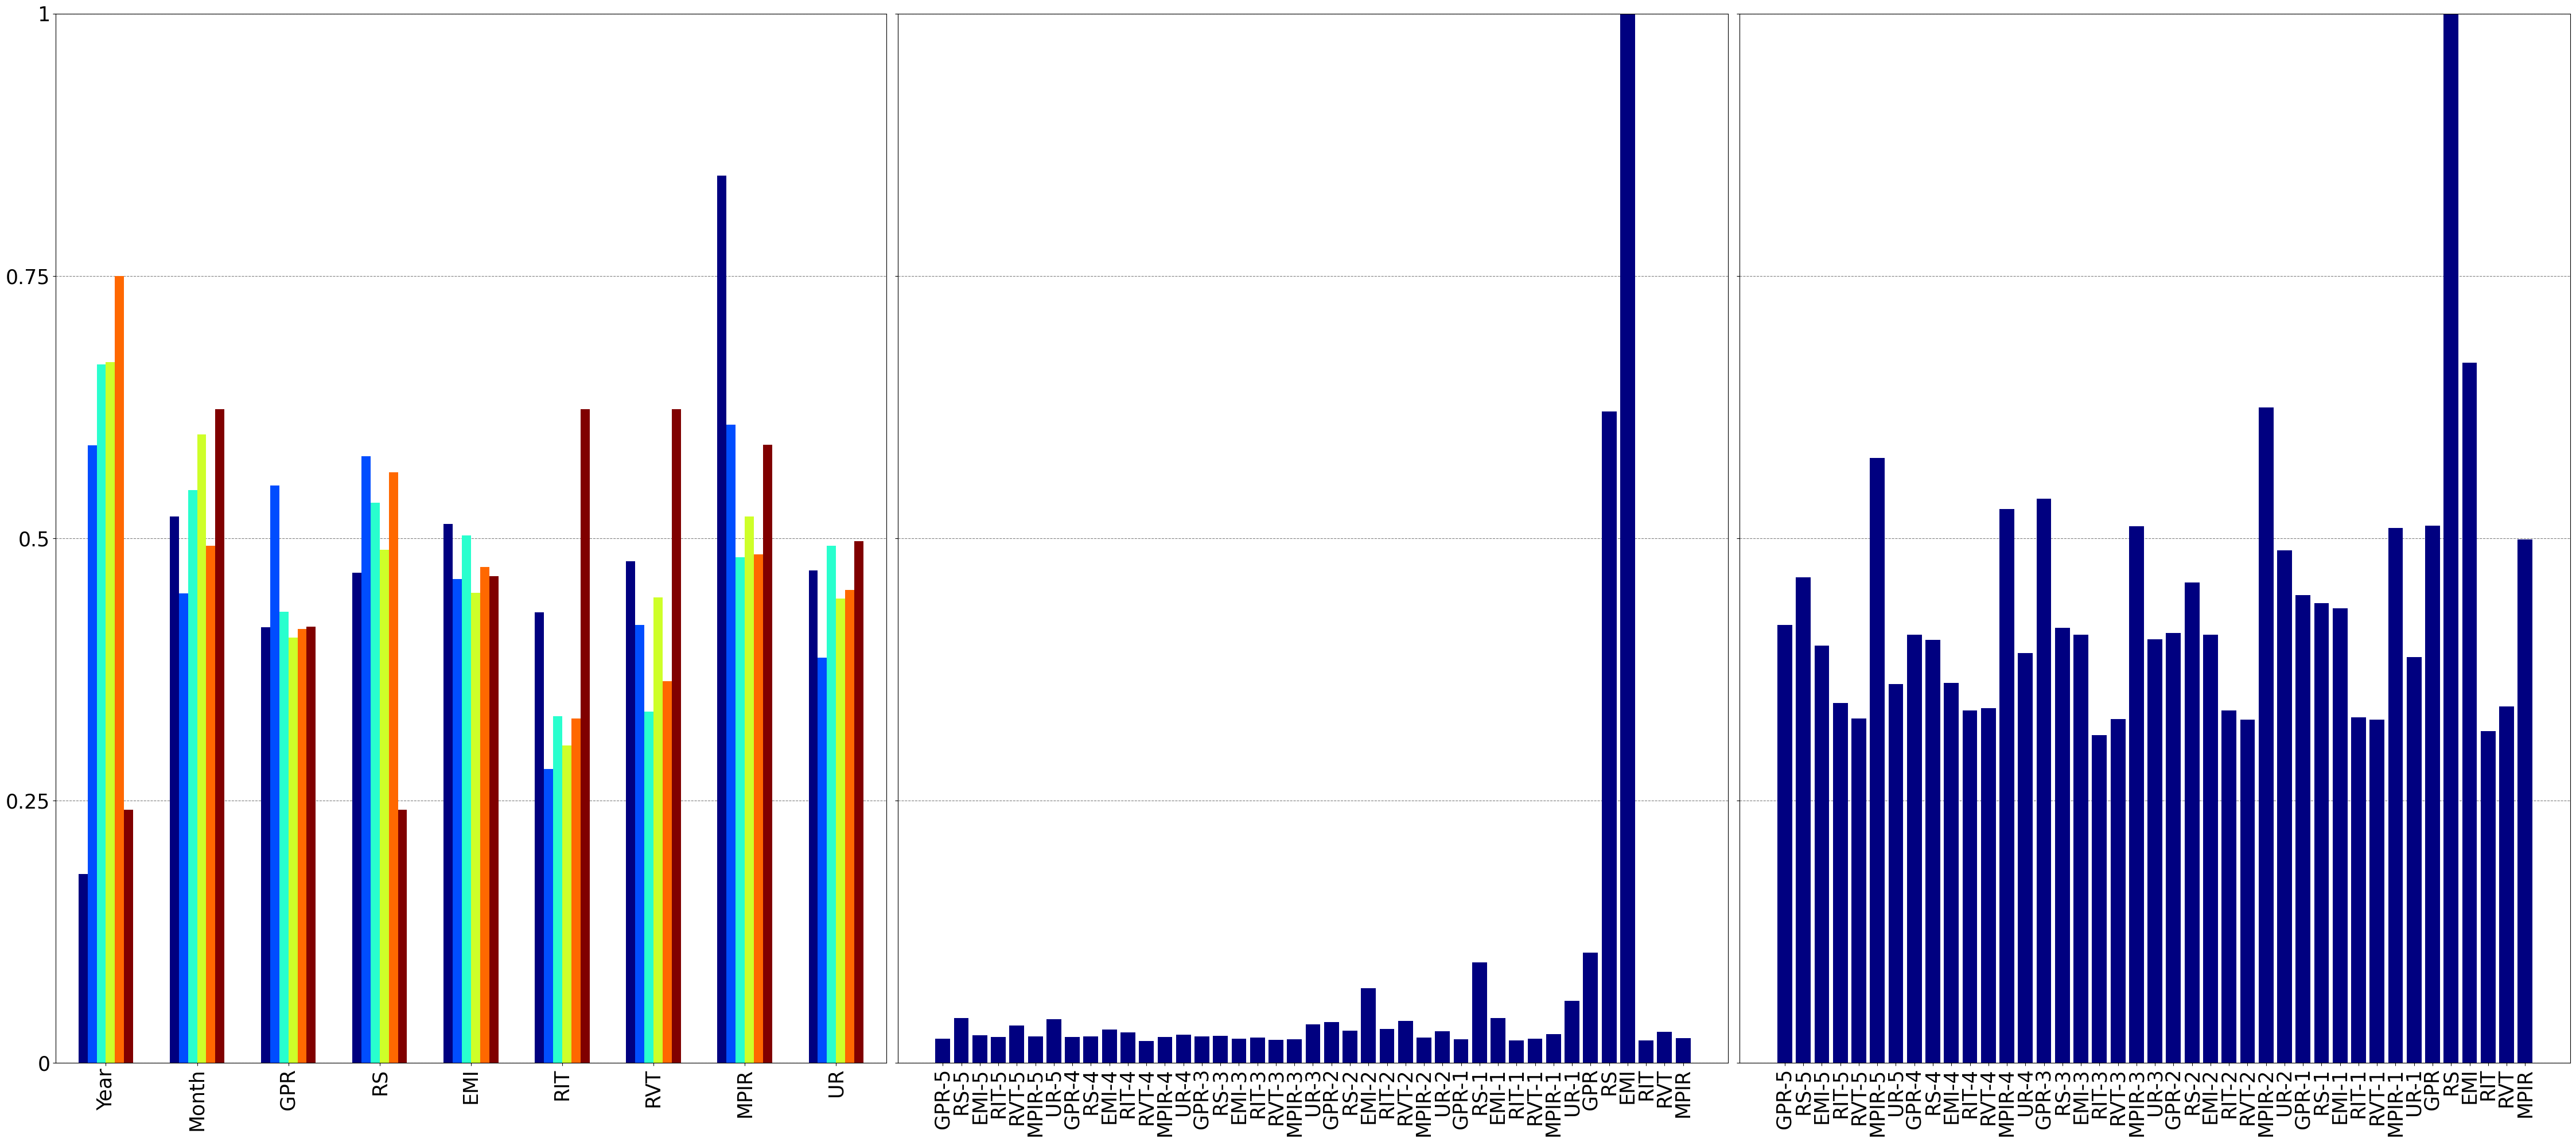

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(45, 20))
# Gráfica 2
relev_.plot.bar(rot=45, ax=ax1, color=cmap_, fontsize=25, legend=False, width=0.6)
ax1.set_xticks(np.arange(len(relev_.index)),labels=relev_.index, rotation=90,fontsize=25)
#ax1.set_yticks([0, 0.25, 0.5, 0.75, 1])
#ax1.set_yticklabels(['0','0.25', '0.5', '0.75', '1'])
#ax1.set_yticklabels([])
#ax2.set_ylabel("Normalized relevance score", fontsize=22)
ax1.set_axisbelow(True)
ax1.grid(axis='y', color='gray', linestyle='dashed')
ax1.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax1.set_yticklabels(['0','0.25', '0.5', '0.75', '1'], fontsize=25)
#ax1.set_xticklabels([])
#ax2.set_title('Gráfica 2')
i=0
archivo, columna =  (f'{path}12 Meses/Params/GP_0.xlsx', 'length_scale')
normalizado = cargar_y_normalizar(archivo, columna, s=i)
ax2.bar(np.arange(len(b)), normalizado,color=cmap_[0],width=0.8)
# Estas etiquetas se asignan por defecto, pero luego
# las “borramos” según la posición de la celda.
ax2.set_axisbelow(True)
ax2.grid(axis='y', color='gray', linestyle='dashed')
ax2.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax2.set_yticklabels([])
ax2.set_ylim(0,1)
ax2.set_xticks(np.arange(len(b)),labels=b, rotation=90,fontsize=25)
i=1
archivo, columna =  (f'{path}12 Meses/Params/GP_1.xlsx', 'length_scale')
normalizado = cargar_y_normalizar(archivo, columna, s=i)
ax3.bar(np.arange(len(b)), normalizado,color=cmap_[0],width=0.8)
# Estas etiquetas se asignan por defecto, pero luego
# las “borramos” según la posición de la celda.
ax3.set_axisbelow(True)
ax3.grid(axis='y', color='gray', linestyle='dashed')
ax3.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax3.set_yticklabels([])
ax3.set_ylim(0,1)
ax3.set_xticks(np.arange(len(b)),labels=b, rotation=90,fontsize=25)

plt.tight_layout()
fig.savefig('12MergeG.pdf')
plt.show()